In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.gridspec import GridSpec

def safe_convert_to_float(value):
    try:
        return float(value)
    except ValueError:
        base, _, exponent = value.partition('e')
        exponent = exponent.replace('.1', '')
        return float(f"{base}e{exponent}")

#Get Wave Electric Spectrogram data
frequency_test_path = '011222frequency_jan.txt'
frequency_test_df = pd.read_csv(frequency_test_path, header=0, sep="\s+", engine='python')
frequency_hz = np.array([safe_convert_to_float(f) for f in frequency_test_df.columns[3:]]) 
mshell_values = frequency_test_df['Mshell'].values
T, F = np.meshgrid(mshell_values, frequency_hz)  #Organize grid based on M-shell and frequency

#Get Wave Magnetic Spectrogram data
frequency_test_path_bw = '011222frequency_jan_bw.txt'
frequency_test_df_bw = pd.read_csv(frequency_test_path_bw, header=0, sep="\s+", engine='python')
frequency_hz_bw = np.array([safe_convert_to_float(f) for f in frequency_test_df_bw.columns[3:]])
mshell_values_bw = frequency_test_df_bw['MShell'].values
T_bw, F_bw = np.meshgrid(mshell_values_bw, frequency_hz_bw) #Organize grid based on M-shell and frequency
magnetic_spectral_density = frequency_test_df_bw.iloc[:, 3:].values
magnetic_spectral_density = magnetic_spectral_density.T #Transpose data to match grid
fce = frequency_test_df_bw['fce'] #get electron cyclotron frequency data

# Get background intensities for each frequency channel
mag_flipped = magnetic_spectral_density.T
n_t, n_fre = mag_flipped.shape
bw_background = np.zeros(n_fre)
ind_background = int(n_t * 0.2)  # 20th percentile index 

# Calculate background level for each frequency channel
for fff in range(n_fre):
    sorted_indices = np.argsort(mag_flipped[:, fff])
    bw_background[fff] = mag_flipped[sorted_indices[ind_background], fff]

# Initialize lists for chorus (int_wave) and hiss (int_hiss) 
int_wave = []
int_hiss = []

''' 
Loop by time and integrate over proper frequency range 
 0.05 fce to fce for whistler-mode chorus waves
 fcp (or 80 for this situation, as it is >fcp and the lowest available frequency) to 0.05 fce for Hiss
'''
for i in range(len(frequency_test_df_bw['fce'])):
    fce_value = fce[i]
    if fce_value < 1.56e4:
        int_range = [j for j in range(len(frequency_hz_bw)) if 0.05 * fce_value <= frequency_hz_bw[j] <= fce_value]
        int_range_hiss = [j for j in range(len(frequency_hz_bw)) if 80 <= frequency_hz_bw[j] <= 0.05 * fce_value]
    else:
        int_range = [j for j in range(len(frequency_hz_bw)) if 0.05 * fce_value <= frequency_hz_bw[j] <= 1.56e4]
        int_range_hiss = [j for j in range(len(frequency_hz_bw)) if 80 <= frequency_hz_bw[j] <= 0.05 * fce_value]                              

    # Filter values and keep those above 5x background
    thresholded_indices_wave = [
        j for j in int_range if mag_flipped[i, j] >= 5 * bw_background[j]
    ]
    thresholded_indices_hiss = [
        j for j in int_range_hiss if mag_flipped[i, j] >= 5 * bw_background[j]
    ]
    # Integrate values that meet the threshold criteria
    if thresholded_indices_wave:
        int_wave.append(np.trapz(mag_flipped[i, thresholded_indices_wave], x=frequency_hz_bw[thresholded_indices_wave]))
    else:
        int_wave.append(0)  # 0 if condition not met

    if thresholded_indices_hiss:
        int_hiss.append(np.trapz(mag_flipped[i, thresholded_indices_hiss], x=frequency_hz_bw[thresholded_indices_hiss]))
    else:
        int_hiss.append(0)  # 0 condition not met

'''
Perform similar operation for ECH waves
Find amplitude by integrating ECH waves from fce to 8 fce, which is an arbitrary limit here
UH waves are not filtered here, but are filtered for modeled diffusion
'''
fce = frequency_test_df['fce']
int_wave_ECH=[]

electric_spectral_density = frequency_test_df.iloc[:, 3:].values
dbw_y = electric_spectral_density
n_t, n_fre = dbw_y.shape
bw_background = np.zeros(n_fre)
ind_background = int(n_t * 0.2)
for fff in range(n_fre):
    sorted_indices = np.argsort(dbw_y[:, fff])
    bw_background[fff] = dbw_y[sorted_indices[ind_background], fff]

for i in range(len(fce)):
    # Find indices that satisfy frequency_hz >= fce[i] and frequency_hz <= 8 * fce[i]
    list1 = np.where(frequency_hz >= fce[i])[0]
    list2 = np.where(frequency_hz <= 8 * fce[i])[0]
    int_range = sorted(list(set(list1) & set(list2)))
    # Apply background conditions
    thresholded_indices = [
        j for j in int_range if j < len(frequency_hz) and electric_spectral_density[i, j] >= 5 * bw_background[j]
    ]
    if thresholded_indices:
        int_wave_ECH.append(np.trapz(electric_spectral_density[i, thresholded_indices], x=frequency_hz[thresholded_indices]))
    else:
        int_wave_ECH.append(0)  # 0 if no conditions met

C:\Users\alecd\AppData\Local\Temp\ipykernel_8012\2605457525.py:14: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pivot_table = grouped_data.pivot("energy", "Mshell", "flux")
C:\Users\alecd\AppData\Local\Temp\ipykernel_8012\2605457525.py:18: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pivot_table_all_JEDI = grouped_data_all_JEDI.pivot("pitch_angle", "Mshell", "flux")
C:\Users\alecd\AppData\Local\Temp\ipykernel_8012\2605457525.py:24: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pivot_table_JADE_all = grouped_data_JADE_all.pivot("pitch_angle", "Mshell", "flux")
C:\Users\alecd\AppData\Local\Temp\ipykernel_8012\2605457525.py:29: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pivot_table_jade = grouped_data_jade.pivot("Energy", "Mshell", "Flux")
C:\Users\alecd\AppData\L

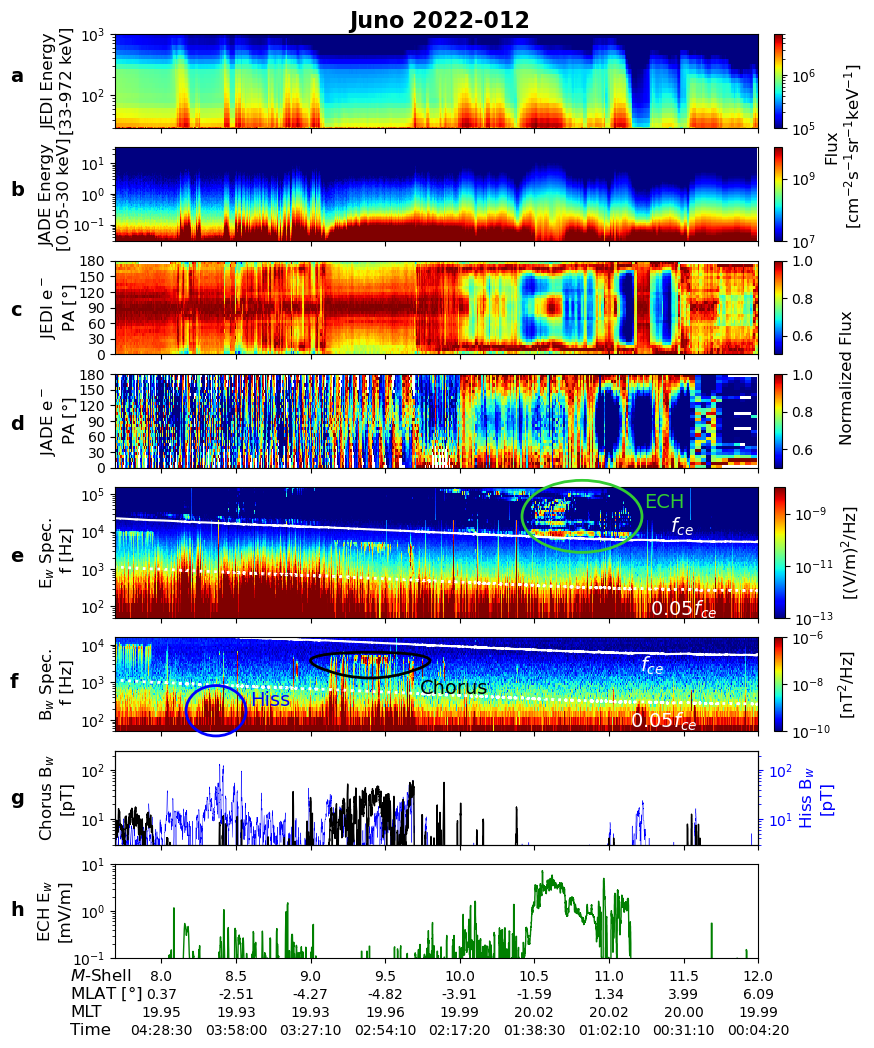

In [2]:
import matplotlib.ticker as mticker
import matplotlib.colors as colors
'''Code used to produce Figure 4'''

gen_loc_data = pd.read_csv('gen_location.txt',delim_whitespace=True) #Spacecraft location
Time_loc = gen_loc_data['Time'] #Time at each location
Mshell_loc = gen_loc_data['Mshell'] #Mshell 
MLAT_loc = gen_loc_data['MagLat'] #Magnetic latitude
MLT_loc = gen_loc_data['MLT'] #Magnetic local time
R_loc = gen_loc_data['R'] #R position

data = pd.read_csv('flux_pad_JADE_JEDI_Jan_early_all.txt', delim_whitespace=True) #Time, Mshell, energy, pitch_angle, flux information from JEDI over equatorial region 
grouped_data = data.groupby(['Mshell', 'energy'])['flux'].mean().reset_index() #Average over all pitch angles
pivot_table = grouped_data.pivot("energy", "Mshell", "flux")

filtered_data_all_JEDI = data[data['energy']>30]  # All JEDI data above 30 keV
grouped_data_all_JEDI = filtered_data_all_JEDI.groupby(['Mshell', 'pitch_angle'])['flux'].mean().reset_index() #Average flux of all JEDI energy channels as a function of Mshell and pitch angle 
pivot_table_all_JEDI = grouped_data_all_JEDI.pivot("pitch_angle", "Mshell", "flux")
normalized_flux = pivot_table_all_JEDI.div(pivot_table_all_JEDI.max(axis=0), axis=1) # Normalize the flux at each Mshell

data_jade_all = pd.read_csv('flux_pad_JADE_JEDI_Jan_early_JADE.txt', delim_whitespace=True) #Get JADE data
filtered_data_JADE_all = data_jade_all[data_jade_all['energy']<30]  # Use JADE data below 30 keV
grouped_data_JADE_all = filtered_data_JADE_all.groupby(['Mshell', 'pitch_angle'])['flux'].mean().reset_index() #Average flux over all JADE channels as a function of Mshell and pitch angle 
pivot_table_JADE_all = grouped_data_JADE_all.pivot("pitch_angle", "Mshell", "flux")
normalized_flux_jade = pivot_table_JADE_all.div(pivot_table_JADE_all.max(axis=0), axis=1) # Normalize the flux at each Mshell

data_jade = pd.read_csv('spin_average_JADE_jan_early.txt', delim_whitespace=True) #Get spin averaged JADE data
grouped_data_jade = data_jade.groupby(['Mshell', 'Energy'])['Flux'].mean().reset_index() #Average of flux as a function of Mshell and energy
pivot_table_jade = grouped_data_jade.pivot("Energy", "Mshell", "Flux")


ml=7.69  #lower Mshell limit of plot
mh=12   #upper Mshell limit of plot

yaxis_tick_size = 10
cbar_tick_size=10

WA = np.sqrt(np.array(int_wave))*1e3 #Chorus wave amplitude
WA_hiss = np.sqrt(np.array(int_hiss))*1e3 #Hiss wave amplitude
ECH_Amp = np.sqrt(np.array(int_wave_ECH))*1e3 #ECH wave amplitude

WA_series = pd.Series(WA)
WA_ECH_series = pd.Series(ECH_Amp)
WA_hiss_series = pd.Series(WA_hiss)
window_size = 15
rolling_avg_chorus = WA_series.rolling(window=window_size).mean() #get 15 second rolling average of amplitude
rolling_avg_ECH = WA_ECH_series.rolling(window=window_size).mean() #get 15 second rolling average of amplitude
rolling_avg_hiss = WA_hiss_series.rolling(window=window_size).mean() #get 15 second rolling average of amplitude

fig = plt.figure(figsize=(10, 12))  #create figure
gs = GridSpec(8, 1,height_ratios=[1,1,1,1,1.39,1,1,1], figure=fig)

# ######################## FIRST PANEL ##################################
ax1 = fig.add_subplot(gs[0, 0]) 
c = ax1.pcolormesh(pivot_table.columns, pivot_table.index, pivot_table, shading='linear', cmap='jet',norm=colors.LogNorm(vmin=1e5,vmax=6e6))
label = ax1.set_ylabel('JEDI Energy\n[33-972 keV]',fontsize=12)
ax1.set_yscale('log')

cbar1 = fig.colorbar(c, ax=ax1,aspect=12,pad=0.02)
label = cbar1.set_label('Flux\n[cm$^{-2}$s$^{-1}$sr$^{-1}$keV$^{-1}$]',labelpad=20,fontsize=12)
cbar1.ax.yaxis.label.set_verticalalignment('center')  
cbar1.ax.yaxis.label.set_position((0, -0.2)) 
cbar1.ax.tick_params(labelsize=cbar_tick_size)

ax1.tick_params(axis='x', labelsize=10)
ax1.tick_params(axis='y', labelsize=yaxis_tick_size)
ax1.set_ylim(30,1000)
ax1.set_xlim(ml,mh)
ax1.set_xticklabels([])

########################## SECOND PANEL #####################################
axj = fig.add_subplot(gs[1, 0])
c = axj.pcolormesh(pivot_table_jade.columns, pivot_table_jade.index/1000, pivot_table_jade, shading='nearest', cmap='jet', norm = colors.LogNorm(vmin=1e7, vmax=1e10))
cbar = fig.colorbar(c, ax=axj,aspect=12,pad=0.02)
cbar.ax.tick_params(labelsize=cbar_tick_size)
label = axj.set_ylabel('JADE Energy\n[0.05-30 keV]',fontsize=12,labelpad=-0.1)
axj.tick_params(axis='y', labelsize=yaxis_tick_size) 
axj.set_yscale('log')
axj.set_xlim(ml,mh)
axj.set_xticklabels([])
########################## THIRD PANEL #########################################
ax6 = fig.add_subplot(gs[2, 0])
c_normalized = ax6.pcolormesh(normalized_flux.columns, normalized_flux.index, normalized_flux, shading='nearest', cmap='jet', vmin=0.5, vmax=1)

ax6.set_ylabel('JEDI e$^-$\nPA [$\\degree$]', fontsize=12,labelpad=-0.1)
cbar = fig.colorbar(c_normalized, ax=ax6,aspect=12,pad=0.02)
cbar.ax.tick_params(labelsize=cbar_tick_size)
ax6.set_yticks([0,30,60,90,120,150,180])
ax6.set_xticklabels([])
ax6.tick_params(axis='y', labelsize=yaxis_tick_size)  
ax6.set_xlim(ml,mh)
######################### FOURTH PANEL ##########################################
axjall = fig.add_subplot(gs[3, 0])
c_normalized = axjall.pcolormesh(normalized_flux_jade.columns, normalized_flux_jade.index, normalized_flux_jade, shading='nearest', cmap='jet', vmin=0.5, vmax=1)

axjall.set_ylabel('JADE e$^-$\nPA [$\\degree$]', fontsize=12,labelpad=-0.1)
cbar = fig.colorbar(c_normalized, ax=axjall,aspect=12,pad=0.02)
cbar.ax.yaxis.label.set_verticalalignment('center')  
cbar.ax.yaxis.label.set_position((0, 0)) 
cbar.ax.tick_params(labelsize=cbar_tick_size)
axjall.set_yticks([0,30,60,90,120,150,180])
axjall.set_xticklabels([])
axjall.tick_params(axis='y', labelsize=yaxis_tick_size)  
axjall.set_xlim(ml,mh)
######################### FIFTH PANEL ##########################################
ax = fig.add_subplot(gs[4, 0])
spectrogram = ax.pcolormesh(T, F, electric_spectral_density.T, shading='cubic', cmap='jet', norm=LogNorm(vmin=1e-13, vmax=1e-8))
ax.plot(mshell_values, frequency_test_df['fce'], color='white') 
ax.plot(mshell_values, 0.05*frequency_test_df['fce'], color='white', linestyle='dotted',linewidth=2)  

ax.set_ylabel('E$_w$ Spec.\n f [Hz]', fontsize=12)
ax.set_ylim(50, 1.5e5)
ax.set_yscale('log')
ax.set_yscale('log')  
ax.set_ylim(50, 1.5e5)  
ax.set_yticks([1e2, 1e3, 1e4, 1e5])  
ax.yaxis.set_minor_locator(mticker.LogLocator(base=10.0, subs=np.arange(2, 10) * 0.1, numticks=10)) 

cbar = fig.colorbar(spectrogram, ax=ax,aspect=12,pad=0.02)
cbar.set_label('[(V/m)$^2$/Hz]', fontsize=12)
ax.tick_params(axis='x', labelsize=10)
ax.set_xlim(ml,mh)
ax.set_xticklabels([])
cbar.ax.tick_params(labelsize=cbar_tick_size) 
# ###################### SIXTH PANEL #############################################
ax3 = fig.add_subplot(gs[5, 0])
spectrogram_bw = ax3.pcolormesh(T_bw, F_bw, magnetic_spectral_density,shading='linear', cmap='jet', norm=LogNorm(vmin=1e-10, vmax=1e-6))
ax3.plot(mshell_values_bw, frequency_test_df_bw['fce'], color='white')  
ax3.plot(mshell_values_bw, 0.05*frequency_test_df_bw['fce'], color='white', linestyle='dotted',linewidth=2)  

ax3.set_ylabel('B$_w$ Spec.\n f [Hz]', fontsize=12)
ax3.set_ylim(50, 1.56e4)
ax3.set_yscale('log')
cbar = fig.colorbar(spectrogram_bw, ax=ax3,aspect=12,pad=0.02)
cbar.set_label('[nT$^2$/Hz]', fontsize=12)
ax3.tick_params(axis='x', labelsize=10)
ax3.tick_params(axis='y', labelsize=yaxis_tick_size)
ax3.set_xlim(ml,mh)
ax3.set_xticklabels([])
cbar.ax.tick_params(labelsize=cbar_tick_size) 
####################### SEVENTH PANEL #############################################
ax4 = fig.add_subplot(gs[6, 0])
ax42 = ax4.twinx()
ax42.plot(mshell_values[:17006],rolling_avg_hiss,color='blue',linewidth=0.3)
ax4.plot(mshell_values[:17006],rolling_avg_chorus,color='black',linewidth=1)

ax4.set_zorder(3)
ax4.patch.set_alpha(0)  # Make the background of ax4 transparent

ax4.set_ylabel('Chorus B$_w$\n[pT]', fontsize=12)
ax42.set_ylabel('Hiss B$_w$\n[pT]',fontsize=12,color='blue')
ax42.tick_params(axis='y', which='both', colors='blue')  

ax42.set_ylim(3,250)
ax42.set_yscale('log')
ax4.set_ylim(3,250)
ax4.set_yscale('log')
ax4.set_xlim(ml,mh)

ax4.set_xticklabels([])
ax4.tick_params(axis='y', labelsize=yaxis_tick_size)  
ax42.tick_params(axis='y', labelsize=yaxis_tick_size)  
colorbar4 = fig.colorbar(c, ax=ax4,pad=0.02)
colorbar4.ax.set_visible(False) # create dummy colorbar to keep panels aligned
###################### EIGHTH PANEL ###########################################
ax5 = fig.add_subplot(gs[7, 0])
ax5.plot(mshell_values,rolling_avg_ECH,color='green',linewidth=1)
ax5.set_ylim(0.1,10)
ax5.set_yscale('log')
ax5.set_ylabel('ECH E$_w$\n[mV/m]',fontsize=12,labelpad=-0.1)
ax5.xaxis.set_ticklabels([])  
ax5.set_xlim(ml,mh)
ax5.tick_params(axis='y', labelsize=yaxis_tick_size)
colorbar5 = fig.colorbar(c, ax=ax5,aspect=12,pad=0.02)
colorbar5.ax.tick_params(labelsize=cbar_tick_size)
colorbar5.ax.set_visible(False)  # create dummy colorbar to keep panels aligned
##################### Section for positional labels at bottom of plot ##############################
position_copy = ax5.get_position()
ax_lon = fig.add_axes(position_copy)
desired_ticks = np.arange(8, 12.5, 0.5)  
index_x_val = []
for i in desired_ticks:
    difference = np.array(Mshell_loc) - i
    index_find = abs(difference).argmin()
    index_x_val.append(index_find)
ax_lon.plot(Mshell_loc,R_loc,alpha=0) #set transparent. Fake plot used to create aligned X-axis
ax_lon.set_ylim(0,1)
ax_lon.set_xticks(Mshell_loc[index_x_val])
ax_lon.yaxis.set_ticks([]) 
ax_lon.yaxis.set_ticklabels([])  

ax_lon.patch.set_alpha(0)
ax_lon.spines['top'].set_visible(False)
ax_lon.spines['right'].set_visible(False)
ax_lon.spines['left'].set_visible(False)
ax_lon.spines['bottom'].set_visible(False)
ax_lon.tick_params(axis='x', length=0)  
ax_lon.set_position([position_copy.x0, position_copy.y0 - 0.006, position_copy.width, position_copy.height])
ax_lon.set_xlim(ml,mh)
###########################
position_copy_mlat = position_copy  # Using the same base position
ax_mlat = fig.add_axes([position_copy_mlat.x0, position_copy_mlat.y0 - 0.015, position_copy_mlat.width, position_copy_mlat.height])
ax_mlat.plot(Mshell_loc, MLAT_loc, alpha=0)  # Transparent plot to keep ticks only
ax_mlat.set_ylim(0, 1)  
ax_mlat.set_xticks(Mshell_loc[index_x_val])
ax_mlat.set_xticklabels([f"{MLAT_loc[idx]:.2f}" for idx in index_x_val])  # Set MLAT labels
ax_mlat.yaxis.set_ticks([])  
ax_mlat.yaxis.set_ticklabels([])  
ax_mlat.patch.set_alpha(0)
ax_mlat.spines['top'].set_visible(False)
ax_mlat.spines['right'].set_visible(False)
ax_mlat.spines['left'].set_visible(False)
ax_mlat.spines['bottom'].set_visible(False)
ax_mlat.tick_params(axis='x', length=0)  # Set tick length to 0 to hide ticks
ax_mlat.set_xlim(ml, mh)
############################
position_copy_mlt = position_copy  
ax_mlt = fig.add_axes([position_copy_mlt.x0, position_copy_mlt.y0 - 0.03, position_copy_mlt.width, position_copy_mlt.height])
ax_mlt.plot(Mshell_loc, MLT_loc, alpha=0)  # Transparent plot to keep ticks only
ax_mlt.set_ylim(0, 1)  
ax_mlt.set_xticks(Mshell_loc[index_x_val])
ax_mlt.set_xticklabels([f"{MLT_loc[idx]:.2f}" for idx in index_x_val])  # Set MLT labels
ax_mlt.yaxis.set_ticks([])  
ax_mlt.yaxis.set_ticklabels([])  
ax_mlt.patch.set_alpha(0)
ax_mlt.spines['top'].set_visible(False)
ax_mlt.spines['right'].set_visible(False)
ax_mlt.spines['left'].set_visible(False)
ax_mlt.spines['bottom'].set_visible(False)
ax_mlt.tick_params(axis='x', length=0)  # Set tick length to 0 to hide ticks
ax_mlt.set_xlim(ml, mh)
##################################
position_copy_time = position_copy  
ax_time = fig.add_axes([position_copy_time.x0, position_copy_time.y0 - 0.045, position_copy_time.width, position_copy_time.height])
ax_time.plot(Mshell_loc, Time_loc, alpha=0)  # Transparent plot to keep ticks only
ax_time.set_ylim(0, 1)  
ax_time.set_xticks(Mshell_loc[index_x_val])
ax_time.set_xticklabels([f"{Time_loc[idx][11::]:}" for idx in index_x_val])  # Set time labels
ax_time.yaxis.set_ticks([]) 
ax_time.yaxis.set_ticklabels([])  
ax_time.patch.set_alpha(0)
ax_time.spines['top'].set_visible(False)
ax_time.spines['right'].set_visible(False)
ax_time.spines['left'].set_visible(False)
ax_time.spines['bottom'].set_visible(False)
ax_time.tick_params(axis='x', length=0)  # Set tick length to 0 to hide ticks
ax_time.set_xlim(ml, mh)
# ###################################################################
'''circles'''
from matplotlib.patches import Ellipse

circle_chorus = Ellipse((9.4,3800),width=0.8,height=5000,edgecolor='black',facecolor='none',linewidth=2)
ax3.add_patch(circle_chorus)
fig_ax = fig.add_axes([0.16, 0.16, 0.6, 0.6], zorder=10)
fig_ax.axis('off')  # Hide the axes frame
circle_hiss = Ellipse((0.11,0.26),width=0.1,height=0.07,edgecolor='blue',facecolor='none',linewidth=2)
fig_ax.add_patch(circle_hiss)
circle_ech = Ellipse((0.72,0.53),width=0.2,height=0.1,edgecolor='limegreen',facecolor='none',linewidth=2)
fig_ax.add_patch(circle_ech)
####################################
fig.text(0.08, 0.091, '$M$-Shell',fontsize=12)
fig.text(0.08, 0.076, 'MLAT [$\degree$]',fontsize=12)
fig.text(0.08, 0.061, 'MLT',fontsize=12)
fig.text(0.08, 0.046, 'Time',fontsize=12)

fig.text(0.43,0.33,'Chorus',color='black',fontsize=14)
fig.text(0.26,0.32,'Hiss',color='blue',fontsize=14)
fig.text(0.654,0.485,'ECH',color='limegreen',fontsize=14)
fig.text(0.85,0.54,'Normalized Flux',rotation=90,fontsize=12)
label_color = 'black'
fig.text(0.02,0.84,'a',rotation=0,fontsize=14,color=label_color,fontweight='bold')
fig.text(0.02,0.745,'b',rotation=0,fontsize=14,color=label_color,fontweight='bold')
fig.text(0.02,0.645,'c',rotation=0,fontsize=14,color=label_color,fontweight='bold')
fig.text(0.02,0.55,'d',rotation=0,fontsize=14,color=label_color,fontweight='bold')
fig.text(0.02,0.44,'e',rotation=0,fontsize=14,color=label_color,fontweight='bold')
fig.text(0.02,0.335,'f',rotation=0,fontsize=14,color=label_color,fontweight='bold')
fig.text(0.02,0.238,'g',rotation=0,fontsize=14,color=label_color,fontweight='bold')
fig.text(0.02,0.145,'h',rotation=0,fontsize=14,color=label_color,fontweight='bold')
fig.text(0.68,0.464,'$f_{ce}$',fontsize=14,color='white')
fig.text(0.66,0.395,'0.05$f_{ce}$',fontsize=14,color='white')
fig.text(0.65,0.349,'$f_{ce}$',fontsize=14,color='white')
fig.text(0.64,0.302,'0.05$f_{ce}$',fontsize=14,color='white')
plt.suptitle('Juno 2022-012',fontsize=16,x=0.45,y=0.9,fontweight='bold')
plt.show()

C:\Users\alecd\AppData\Local\Temp\ipykernel_8012\392363037.py:182: UserWarning: shading value 'cubic' not in list of valid values ['gouraud', 'nearest', 'flat', 'auto']. Setting shading='auto'.
  spectrogram = axes[0,0].pcolormesh(T, F, electric_spectral_density.T, shading='cubic', cmap=c1plot, norm=LogNorm(vmin=1e-13, vmax=1e-8))
C:\Users\alecd\AppData\Local\Temp\ipykernel_8012\392363037.py:242: UserWarning: shading value 'cubic' not in list of valid values ['gouraud', 'nearest', 'flat', 'auto']. Setting shading='auto'.
  spectrogram = axes[1,0].pcolormesh(T_bw, F_bw, magnetic_spectral_density, shading='cubic', cmap=c1plot, norm=LogNorm(vmin=1e-10, vmax=1e-5))
C:\Users\alecd\AppData\Local\Temp\ipykernel_8012\392363037.py:299: UserWarning: shading value 'cubic' not in list of valid values ['gouraud', 'nearest', 'flat', 'auto']. Setting shading='auto'.
  spectrogram = axes[2,0].pcolormesh(T_bw, F_bw, magnetic_spectral_density, shading='cubic', cmap=c1plot, norm=LogNorm(vmin=1e-10, vmax=

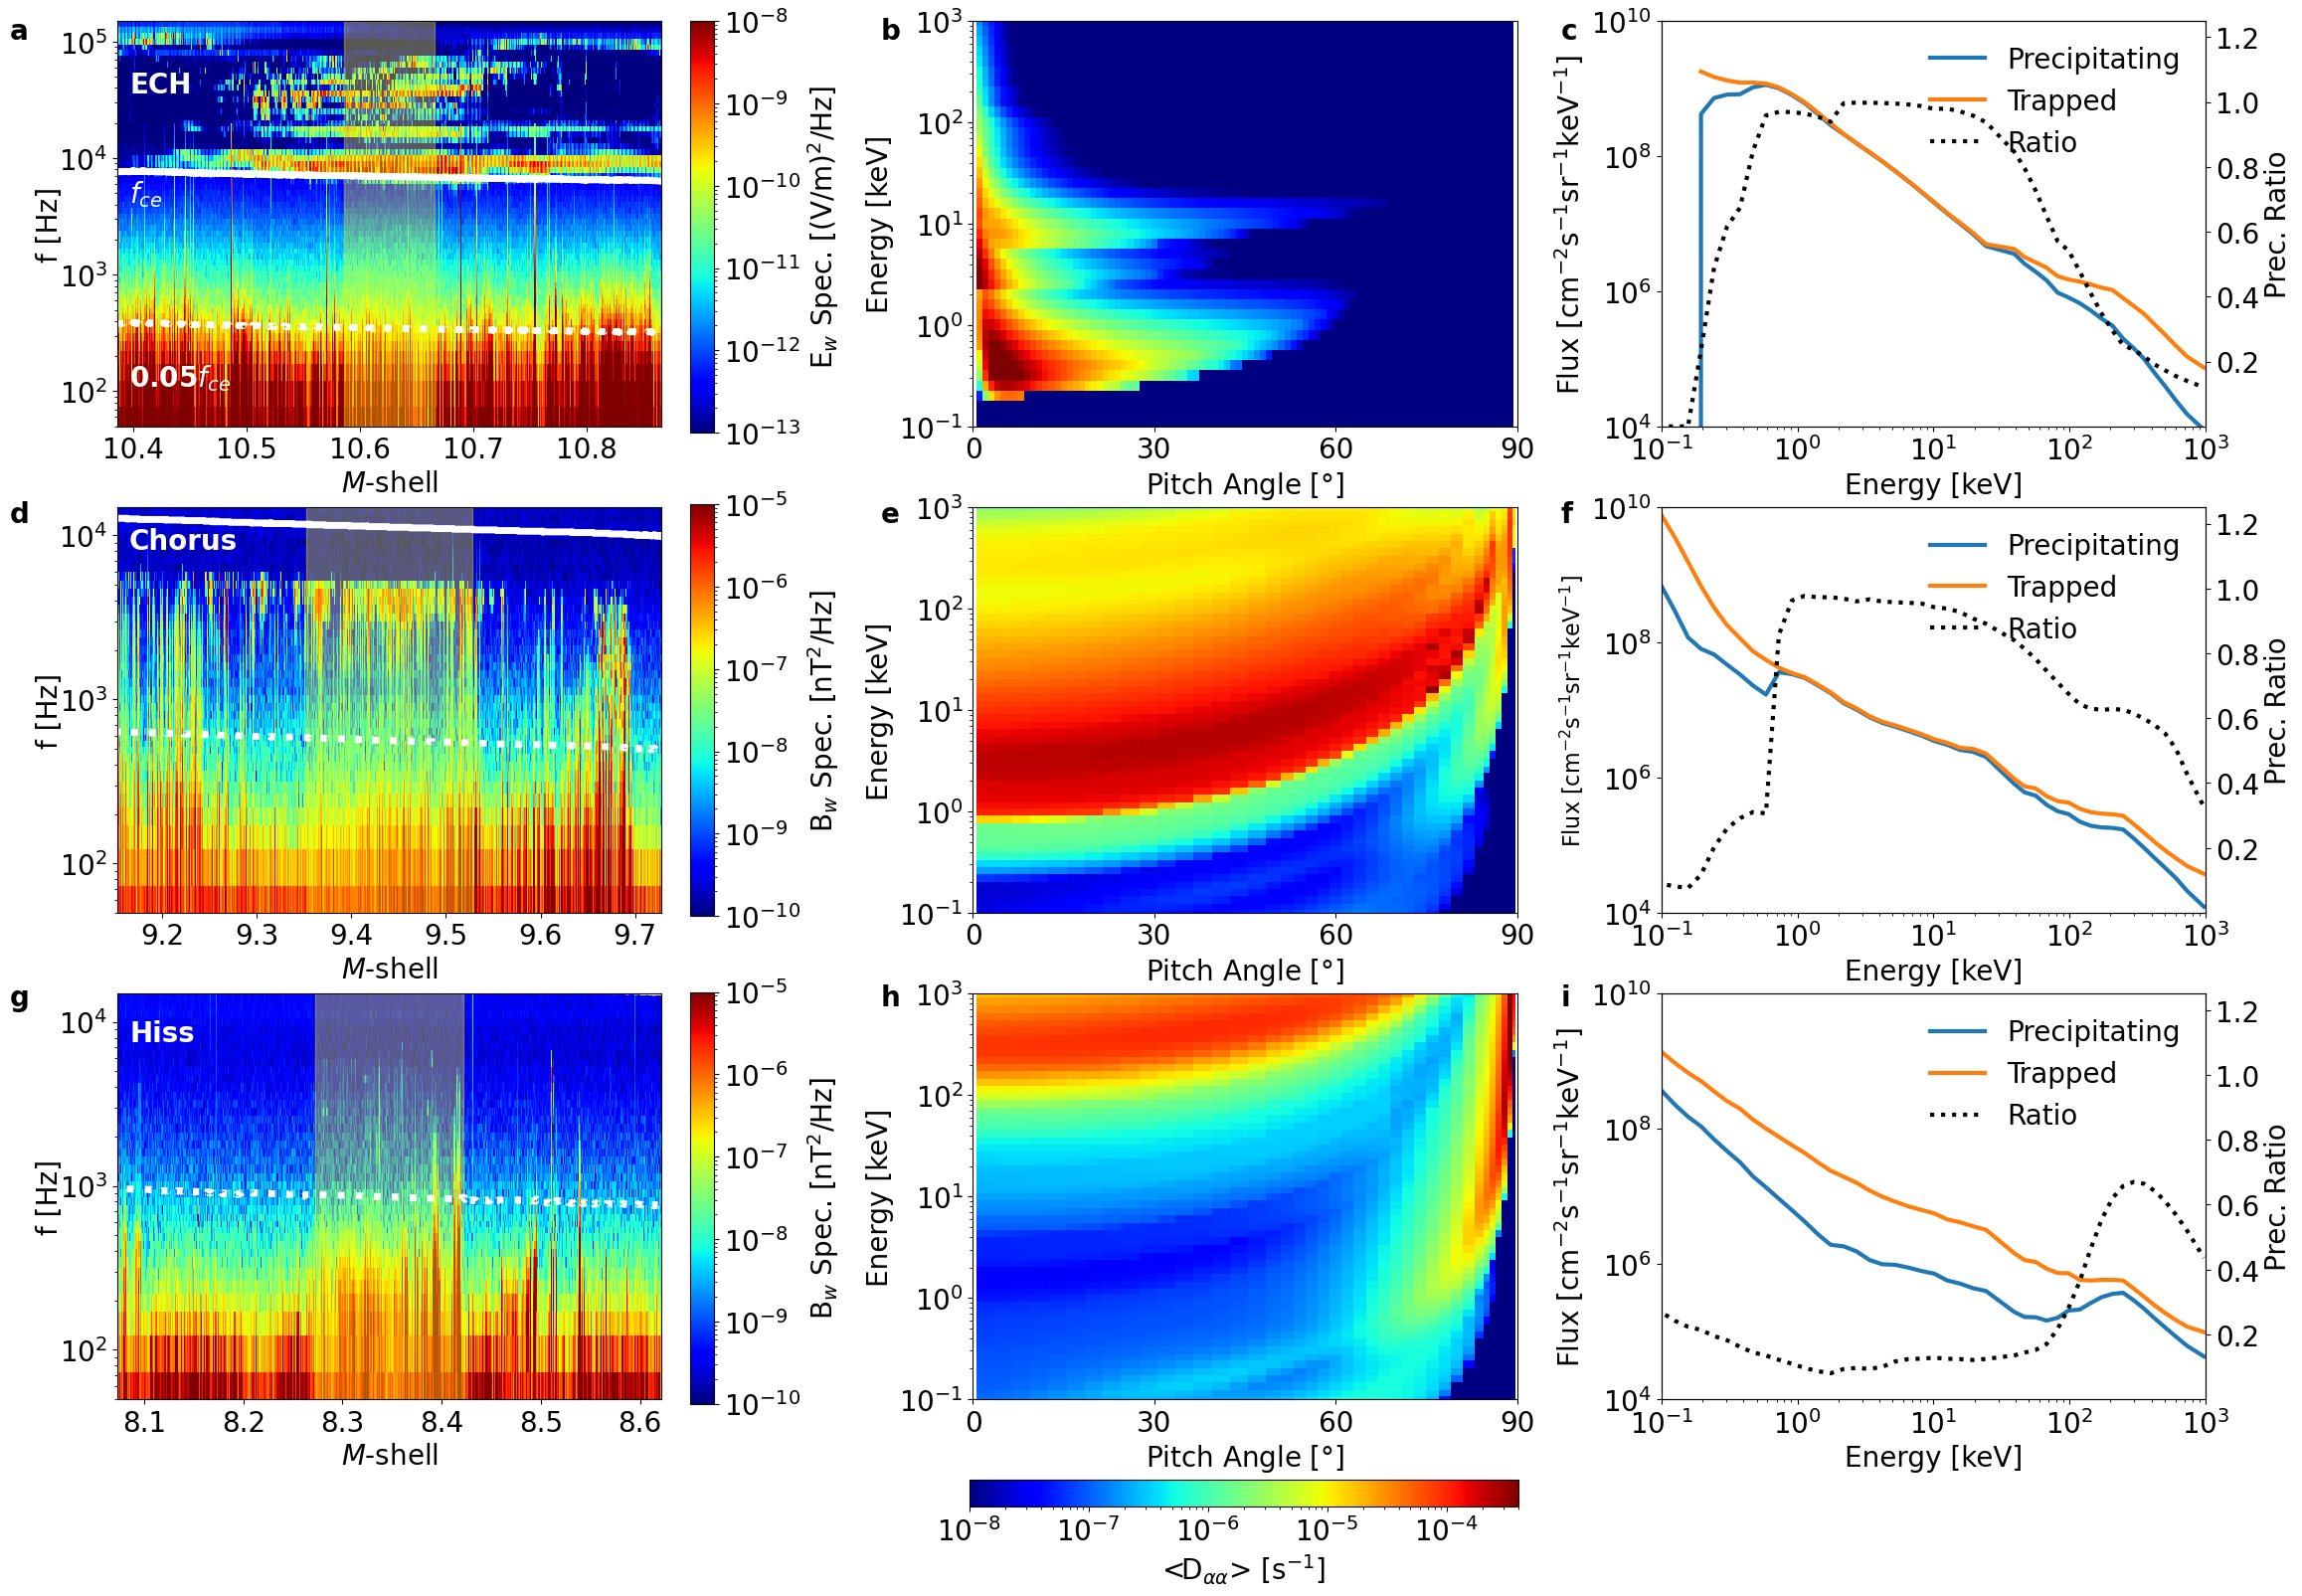

In [3]:
'''Code used to produce Figure 4'''
Diffusion = pd.read_csv('Diffusion_ek_pa_jan_ECH',delim_whitespace=True) # import diffusion results for ECH waves with time, energy, and pitch angle
diffusion = np.array(Diffusion['Daa'])
pitch_angle_diff = np.unique(Diffusion['pitch_angle']) # Get pitch angle information
energy_diff = np.unique(Diffusion['Energy']) # Get energy information

d = Diffusion['Daa'] # Get diffusion coefficient information
num_time_steps = len(Diffusion) // (len(pitch_angle_diff) * len(energy_diff)) #Number of time steps
Daa_values = Diffusion['Daa'].values.reshape(num_time_steps, len(energy_diff), len(pitch_angle_diff)) #Reshape diffusion coefficients into time, energy, pitch angle array
Daa_values[Daa_values == 0] = 1e-18 #No 0 values to keep background one color
Daa_grid = np.mean(Daa_values, axis=0) #Average diffusion coefficient over all time steps (highlighted region)

file_diff = pd.read_csv('Diffusion_jan_ECH.txt', delim_whitespace=True) #import diffusion coefficients with respect to energy and time 
average_daa = file_diff.groupby('Energy', as_index=False)['Daa'].mean() #average diffusion coefficient at each energy across all times
Energy_daa = average_daa['Energy']
daa = average_daa['Daa']

pitch_mask = pitch_angle_diff<=1 
Daa_filtered = Daa_values[:,:,pitch_mask] # Daa when pitch angle < 1 degree
Daa_avg_low_pitch = np.mean(Daa_filtered, axis=(0, 2))

min_t_ind = (np.where(frequency_test_df['Time']==file_diff['time'][0])[0])[0] #match time stamps of Ew file and ECH diffusion file
max_t_ind = (np.where(frequency_test_df['Time']==file_diff['time'][len(file_diff)-1])[0])[0] 
mshell_min = mshell_values[min_t_ind]
mshell_max = mshell_values[max_t_ind]

precipitating_flux_ech = pd.read_csv('precip_eflux_jan_ech.txt',delim_whitespace=True) # Import precipitating flux values
time_precip_ech = precipitating_flux_ech['Time'] 
Energy_precip_ech = precipitating_flux_ech['energy']
Precip_ech = precipitating_flux_ech['flux']

precip_ratio_df = pd.read_csv("precip_ratio_jan_ech.txt", delim_whitespace=True) #import precipitation ratio file
precip_ratio_df["Time"] = pd.to_datetime(precip_ratio_df["Time"], format="%Y-%m-%d/%H:%M:%S")

precipitating_flux_ech['Time'] = pd.to_datetime(precipitating_flux_ech['Time'], format='%Y-%m-%d/%H:%M:%S')
Trapped_flux_ech = data[data['pitch_angle'] == 9.0][['Time', 'energy', 'flux']].reset_index(drop=True)
Trapped_flux_ech['Time'] = pd.to_datetime(Trapped_flux_ech['Time'], format='%Y-%m-%d/%H:%M:%S')

start_time_ech = pd.to_datetime(Diffusion['time'][0], format='%Y-%m-%d/%H:%M:%S')
end_time_ech = pd.to_datetime(Diffusion['time'].iloc[-1], format='%Y-%m-%d/%H:%M:%S')

filtered_precip_ech = precipitating_flux_ech[(precipitating_flux_ech['Time'] >= start_time_ech) & # filter precipitating flux by time range
                                         (precipitating_flux_ech['Time'] <= end_time_ech)]
mean_flux_per_energy_ech = filtered_precip_ech.groupby('energy')['flux'].mean()

filtered_precip_ratio = precip_ratio_df[(precip_ratio_df["Time"] >= start_time_ech) & (precip_ratio_df["Time"] <= end_time_ech)]
avg_ratios = filtered_precip_ratio.groupby("energy")["ratio"].mean().reset_index() #get average precipitation ratio filtered by time range

mean_trap_per_energy_ech = mean_flux_per_energy_ech.values/avg_ratios['ratio'] # Get the trapped flux of the nearest energy channel by using the ratio

########################### SAME BUT FOR CHORUS WAVES ##############################################################
Diffusion_w = pd.read_csv('Diffusion_jan_whistler',delim_whitespace=True)
diffusion_w = np.array(Diffusion_w['Daa'])
diffusion_w[diffusion_w == 0] = 1e-18
pitch_angle_diff_w = np.unique(Diffusion_w['pitch_angle'])
energy_diff_w = np.unique(Diffusion_w['Energy'])*1000

num_time_steps = len(Diffusion_w) // (len(pitch_angle_diff_w) * len(energy_diff_w))
Daa_values_w = Diffusion_w['Daa'].values.reshape(num_time_steps, len(energy_diff_w), len(pitch_angle_diff_w))
Daa_values_w[Daa_values_w == 0] = 1e-18
Daa_grid_w = np.mean(Daa_values_w, axis=0)

file_diff_w = pd.read_csv('Diffusion_jan_whistler.txt', delim_whitespace=True)
average_daa_w = file_diff_w.groupby('Energy', as_index=False)['Daa'].mean()
Energy_daa_w = average_daa_w['Energy']
daa_w = average_daa_w['Daa']

pitch_mask_w = pitch_angle_diff_w<5
Daa_filtered_w = Daa_values_w[:,:,pitch_mask_w]
Daa_avg_low_pitch_w = np.mean(Daa_filtered_w, axis=(0, 2))

min_t_ind_w = (np.where(frequency_test_df['Time']==Diffusion_w['time'][0])[0])[0]
max_t_ind_w = (np.where(frequency_test_df['Time']==Diffusion_w['time'][len(Diffusion_w)-1])[0])[0]

mshell_min_w = mshell_values[min_t_ind_w]
mshell_max_w = mshell_values[max_t_ind_w]

precipitating_flux_w = pd.read_csv('Precip_eflux_jan_5xback.txt',delim_whitespace=True)
time_precip_w = precipitating_flux_w['Time']
Energy_precip_w = precipitating_flux_w['energy']
Precip_w = precipitating_flux_w['flux']

Trapped_flux_w = pd.read_csv('Trapped_eflux_jan_5xback.txt',delim_whitespace=True)
time_trap_w = Trapped_flux_w['Time']
Energy_trap_w = Trapped_flux_w['energy']
Trapped_w = Trapped_flux_w['flux']

precipitating_flux_w['Time'] = pd.to_datetime(precipitating_flux_w['Time'], format='%Y-%m-%d/%H:%M:%S')
Trapped_flux_w['Time'] = pd.to_datetime(Trapped_flux_w['Time'], format='%Y-%m-%d/%H:%M:%S')

start_time = pd.to_datetime(Diffusion_w['time'][0], format='%Y-%m-%d/%H:%M:%S')
end_time = pd.to_datetime(Diffusion_w['time'].iloc[-1], format='%Y-%m-%d/%H:%M:%S')
filtered_precip_w = precipitating_flux_w[(precipitating_flux_w['Time'] >= start_time) & 
                                         (precipitating_flux_w['Time'] <= end_time)]
mean_flux_per_energy_w = filtered_precip_w.groupby('energy')['flux'].mean()
filtered_trap_w = Trapped_flux_w[(Trapped_flux_w['Time'] >= start_time) & 
                                         (Trapped_flux_w['Time'] <= end_time)]

mean_trap_per_energy_w = filtered_trap_w.groupby('energy')['flux'].mean()
############################# SAME BUT FOR HISS WAVES ############################################################
Diffusion_h = pd.read_csv('Diffusion_ek_pa_jan_whistler_hiss.txt',delim_whitespace=True)
diffusion_h = np.array(Diffusion_w['Daa'])
diffusion_h[diffusion_h == 0] = 1e-18
pitch_angle_diff_h = np.unique(Diffusion_h['pitch_angle'])
energy_diff_h = np.unique(Diffusion_h['Energy'])*1000

num_time_steps = len(Diffusion_h) // (len(pitch_angle_diff_h) * len(energy_diff_h))
Daa_values_h = Diffusion_h['Daa'].values.reshape(num_time_steps, len(energy_diff_h), len(pitch_angle_diff_h))
Daa_values_h[Daa_values_h == 0] = 1e-18
Daa_grid_h = np.mean(Daa_values_h, axis=0)

file_diff_h = pd.read_csv('Diffusion_jan_whistler.txt', delim_whitespace=True)
average_daa_h = file_diff_h.groupby('Energy', as_index=False)['Daa'].mean()
Energy_daa_h = average_daa_h['Energy']
daa_h = average_daa_h['Daa']

pitch_mask_h = pitch_angle_diff_h<5
Daa_filtered_h = Daa_values_h[:,:,pitch_mask_h]
Daa_avg_low_pitch_h = np.mean(Daa_filtered_h, axis=(0, 2))

min_t_ind_h = (np.where(frequency_test_df['Time']==Diffusion_h['time'][0])[0])[0]
max_t_ind_h = (np.where(frequency_test_df['Time']==Diffusion_h['time'][len(Diffusion_h)-1])[0])[0]

mshell_min_h = mshell_values[min_t_ind_h]
mshell_max_h = mshell_values[max_t_ind_h]

start_time_h = pd.to_datetime(Diffusion_h['time'][0], format='%Y-%m-%d/%H:%M:%S')
end_time_h = pd.to_datetime(Diffusion_h['time'].iloc[-1], format='%Y-%m-%d/%H:%M:%S')
filtered_precip_h = precipitating_flux_w[(precipitating_flux_w['Time'] >= start_time_h) & 
                                         (precipitating_flux_w['Time'] <= end_time_h)]
mean_flux_per_energy_h = filtered_precip_h.groupby('energy')['flux'].mean()
filtered_trap_h = Trapped_flux_w[(Trapped_flux_w['Time'] >= start_time_h) & 
                                         (Trapped_flux_w['Time'] <= end_time_h)]
mean_trap_per_energy_h = filtered_trap_h.groupby('energy')['flux'].mean()
############################### CREATE PLOT ####################################################
width=3
font_use = 20
midplot = 'jet'
c1plot = 'jet'
fig, axes = plt.subplots(3, 3, figsize=(24, 18), gridspec_kw={'width_ratios': [1, 1, 1]})
pcm = axes[0,1].pcolormesh(pitch_angle_diff, energy_diff, Daa_grid, cmap=midplot, 
                         norm=colors.LogNorm(vmin=1e-8, vmax=4e-4), shading='auto')
axes[0,1].set_yscale('log')
axes[0,1].set_xlim(0, 90)
axes[0,1].set_xlabel('Pitch Angle [$\degree$]',fontsize=font_use)
axes[0,1].set_ylabel('Energy [keV]', fontsize=font_use)
axes[0,1].set_ylim(1e-1, 1e3)
axes[0,1].tick_params(axis='x', labelsize=font_use)
axes[0,1].tick_params(axis='y', labelsize=font_use)
axes[0,1].set_xticks([0,30,60,90])

# Create separate axis for the colorbar
cbar_ax = fig.add_axes([0.482, 0.05, 0.23, 0.015])  # [left, bottom, width, height]
cbar = fig.colorbar(pcm, cax=cbar_ax, orientation='horizontal')
cbar.set_label('<D$_{\\alpha\\alpha}$> [s$^{-1}$]', fontsize=font_use)
cbar.ax.tick_params(labelsize=font_use)

axes[0,2].plot(mean_flux_per_energy_ech.index, mean_flux_per_energy_ech.values\
               , linestyle='-',label='Precipitating',linewidth=width)
axes[0,2].plot(mean_flux_per_energy_ech.index, mean_trap_per_energy_ech\
               , linestyle='-',label='Trapped',linewidth=width)
axes[0,2].set_yscale('log')
axes[0,2].set_xscale('log')
axes[0,2].set_xlabel('Energy [keV]', fontsize=font_use)
axes[0,2].set_xlim(1e-1,1e3)
axes[0,2].set_ylim(1e4,1e10)
axes[0,2].set_ylabel('Flux [cm$^{-2}$s$^{-1}$sr$^{-1}$keV$^{-1}$]', fontsize=font_use)
axes[0,2].tick_params(axis='x', labelsize=font_use)
axes[0,2].tick_params(axis='y', labelsize=font_use)
ax02 = axes[0,2].twinx()
line3, = ax02.plot(avg_ratios["energy"], avg_ratios["ratio"], color='black', linestyle='dotted', label='Ratio',linewidth=width)
ax02.set_xlim(1e-1,1e3)
ax02.set_ylim(0,1.25)
ax02.tick_params(axis='x', labelsize=font_use)
ax02.tick_params(axis='y', labelsize=font_use)
ax02.set_ylabel('Prec. Ratio', fontsize=font_use)
ax02.set_yticks([0.2,0.4,0.6,0.8,1,1.2])
lines1, labels1 = axes[0,2].get_legend_handles_labels()
lines2, labels2 = ax02.get_legend_handles_labels()
axes[0,2].legend(lines1 + [line3], labels1 + ['Ratio'], fontsize=font_use, frameon=False, loc='upper right')

spectrogram = axes[0,0].pcolormesh(T, F, electric_spectral_density.T, shading='cubic', cmap=c1plot, norm=LogNorm(vmin=1e-13, vmax=1e-8))
axes[0,0].plot(mshell_values, frequency_test_df['fce'], color='white',linewidth=5)  # fce plotted against Mshell
axes[0,0].plot(mshell_values, 0.05*frequency_test_df['fce'], color='white', linestyle='dotted',linewidth=5)  # fce plotted against Mshell
axes[0,0].set_ylabel('f [Hz]', fontsize=font_use,labelpad=-3)
axes[0,0].set_ylim(50, 1.5e5)
axes[0,0].set_yscale('log')

cbar_ew = fig.add_axes([0.365, 0.65, 0.01, 0.23])  # [left, bottom, width, height]
cbar = fig.colorbar(spectrogram, cax=cbar_ew)
cbar.set_label('E$_w$ Spec. [(V/m)$^2$/Hz]', fontsize=font_use)
axes[0,0].set_xlabel('$M$-shell',fontsize=font_use)
axes[0,0].tick_params(axis='x', labelsize=font_use)
axes[0,0].tick_params(axis='y', labelsize=font_use)
cbar.ax.tick_params(labelsize=font_use)
if mshell_max>=mshell_min:
    axes[0,0].set_xlim(mshell_min-0.2,mshell_max+0.2)
    axes[0,0].axvspan(mshell_min,mshell_max,color='yellow',alpha=0.35)

else:
    axes[0,0].set_xlim(mshell_max-0.2,mshell_min+0.2)
    axes[0,0].axvspan(mshell_min,mshell_max,color='yellow',alpha=0.35)
#####################################################################################################
pcm = axes[1,1].pcolormesh(pitch_angle_diff_w, energy_diff_w, Daa_grid_w, cmap=midplot, 
                         norm=colors.LogNorm(vmin=1e-8, vmax=4e-4), shading='auto')
axes[1,1].set_yscale('log')
axes[1,1].set_xlim(0, 90)
axes[1,1].set_xlabel('Pitch Angle [$\degree$]',fontsize=font_use)
axes[1,1].set_ylabel('Energy [keV]', fontsize=font_use)
axes[1,1].set_ylim(1e-1, 1e3)
axes[1,1].tick_params(axis='x', labelsize=font_use)
axes[1,1].tick_params(axis='y', labelsize=font_use)
axes[1,1].set_xticks([0,30,60,90])

axes[1,2].plot(mean_flux_per_energy_w.index/1000, mean_flux_per_energy_w.values, linestyle='-'\
               ,label='Precipitating',linewidth=width)
axes[1,2].plot(mean_trap_per_energy_w.index/1000, mean_trap_per_energy_w.values, linestyle='-'\
               ,label='Trapped',linewidth=width)

axes[1,2].set_yscale('log')
axes[1,2].set_xscale('log')
axes[1,2].set_xlabel('Energy [keV]', fontsize=font_use)
axes[1,2].set_xlim(1e-1,1e3)
axes[1,2].set_ylim(1e4,1e10)
axes[1,2].set_ylabel('Flux [cm$^{-2}$s$^{-1}$sr$^{-1}$keV$^{-1}$]', fontsize=16)
axes[1,2].tick_params(axis='x', labelsize=font_use)
axes[1,2].tick_params(axis='y', labelsize=font_use)
axes[1,2].legend(fontsize=font_use,frameon=False)
ax12 = axes[1,2].twinx()
line3, = ax12.plot(mean_trap_per_energy_w.index/1000, mean_flux_per_energy_w.values/mean_trap_per_energy_w.values,\
                   color='black',linestyle='dotted',label = 'Ratio',linewidth=width)
ax12.set_xlim(1e-1,1e3)
ax12.set_ylim(0,1.25)
ax12.tick_params(axis='x', labelsize=font_use)
ax12.tick_params(axis='y', labelsize=font_use)
ax12.set_ylabel('Prec. Ratio', fontsize=font_use)
ax12.set_yticks([0.2,0.4,0.6,0.8,1,1.2])
lines1, labels1 = axes[1,2].get_legend_handles_labels()
lines2, labels2 = ax02.get_legend_handles_labels()
axes[1,2].legend(lines1 + [line3], labels1 + ['Ratio'], fontsize=font_use, frameon=False, loc='upper right')

spectrogram = axes[1,0].pcolormesh(T_bw, F_bw, magnetic_spectral_density, shading='cubic', cmap=c1plot, norm=LogNorm(vmin=1e-10, vmax=1e-5))
axes[1,0].plot(mshell_values, frequency_test_df['fce'], color='white',linewidth=5)  # fce plotted against Mshell
axes[1,0].plot(mshell_values, 0.05*frequency_test_df['fce'], color='white', linestyle='dotted',linewidth=5)  # fce plotted against Mshell
axes[1,0].set_yscale('log')
cbar = fig.add_axes([0.365, 0.38, 0.01, 0.23])  # [left, bottom, width, height]
cbar = fig.colorbar(spectrogram, cax=cbar)
cbar.set_label('B$_w$ Spec. [nT$^2$/Hz]', fontsize=font_use)
axes[1,0].set_ylabel('f [Hz]', fontsize=font_use,labelpad=-3)
axes[1,0].set_ylim(50, 1.48e4)
axes[1,0].set_xlabel('$M$-shell',fontsize=font_use)
axes[1,0].tick_params(axis='x', labelsize=font_use)
axes[1,0].tick_params(axis='y', labelsize=font_use)
cbar.ax.tick_params(labelsize=font_use)
if mshell_max_w>=mshell_min_w:
    axes[1,0].set_xlim(mshell_min_w-0.2,mshell_max_w+0.2)
    axes[1,0].axvspan(mshell_min_w,mshell_max_w,color='yellow',alpha=0.35)
else:
    axes[1,0].set_xlim(mshell_max_w-0.2,mshell_min_w+0.2)
    axes[1,0].axvspan(mshell_max_w,mshell_min_w,color='yellow',alpha=0.35)
#####################################################################################################
pcm = axes[2,1].pcolormesh(pitch_angle_diff_h, energy_diff_h, Daa_grid_h, cmap=midplot, 
                         norm=colors.LogNorm(vmin=1e-8, vmax=4e-4), shading='auto')
axes[2,1].set_yscale('log')
axes[2,1].set_xlim(0, 90)
axes[2,1].set_xlabel('Pitch Angle [$\degree$]',fontsize=font_use)
axes[2,1].set_ylabel('Energy [keV]', fontsize=font_use)
axes[2,1].set_ylim(1e-1, 1e3)
axes[2,1].tick_params(axis='x', labelsize=font_use)
axes[2,1].tick_params(axis='y', labelsize=font_use)
axes[2,1].set_xticks([0,30,60,90])

axes[2,2].plot(mean_flux_per_energy_h.index/1000, mean_flux_per_energy_h.values\
               , linestyle='-',label='Precipitating',linewidth=width)
axes[2,2].plot(mean_trap_per_energy_h.index/1000, mean_trap_per_energy_h.values\
               , linestyle='-',label='Trapped',linewidth=width)
axes[2,2].set_yscale('log')
axes[2,2].set_xscale('log')
axes[2,2].set_xlabel('Energy [keV]', fontsize=font_use)
axes[2,2].set_xlim(1e-1,1e3)
axes[2,2].set_ylim(1e4,1e10)
axes[2,2].set_ylabel('Flux [cm$^{-2}$s$^{-1}$sr$^{-1}$keV$^{-1}$]', fontsize=font_use)
axes[2,2].tick_params(axis='x', labelsize=font_use)
axes[2,2].tick_params(axis='y', labelsize=font_use)
axes[2,2].legend(fontsize=font_use,frameon=False)
ax22 = axes[2,2].twinx()
line3, = ax22.plot(mean_trap_per_energy_h.index/1000, mean_flux_per_energy_h.values/mean_trap_per_energy_h.values\
                   ,color='black',linestyle='dotted',label = 'Ratio',linewidth=width)
ax22.set_xlim(1e-1,1e3)
ax22.set_ylim(0,1.25)
ax22.tick_params(axis='x', labelsize=font_use)
ax22.tick_params(axis='y', labelsize=font_use)
ax22.set_ylabel('Prec. Ratio', fontsize=font_use)
ax22.set_yticks([0.2,0.4,0.6,0.8,1,1.2])
lines1, labels1 = axes[2,2].get_legend_handles_labels()
lines2, labels2 = ax02.get_legend_handles_labels()
axes[2,2].legend(lines1 + [line3], labels1 + ['Ratio'], fontsize=font_use, frameon=False, loc='upper right')

spectrogram = axes[2,0].pcolormesh(T_bw, F_bw, magnetic_spectral_density, shading='cubic', cmap=c1plot, norm=LogNorm(vmin=1e-10, vmax=1e-5))
axes[2,0].plot(mshell_values, frequency_test_df['fce'], color='white',linewidth=5)  # fce plotted against Mshell
axes[2,0].plot(mshell_values, 0.05*frequency_test_df['fce'], color='white', linestyle='dotted',linewidth=5)  # fce plotted against Mshell
axes[2,0].set_yscale('log')

cbar = fig.add_axes([0.365, 0.1075, 0.01, 0.23])  # [left, bottom, width, height]
cbar = fig.colorbar(spectrogram, cax=cbar)
cbar.set_label('B$_w$ Spec. [nT$^2$/Hz]', fontsize=font_use)
axes[2,0].set_ylabel('f [Hz]', fontsize=font_use,labelpad=-3)
axes[2,0].set_ylim(50, 1.48e4)
axes[2,0].set_xlabel('$M$-shell',fontsize=font_use)
axes[2,0].tick_params(axis='x', labelsize=font_use)
axes[2,0].tick_params(axis='y', labelsize=font_use)
cbar.ax.tick_params(labelsize=font_use)
if mshell_max_h>=mshell_min_h:
    axes[2,0].set_xlim(mshell_min_h-0.2,mshell_max_h+0.2)
    axes[2,0].axvspan(mshell_min_h,mshell_max_h,color='yellow',alpha=0.35)

else:
    axes[2,0].set_xlim(mshell_max_h-0.2,mshell_min_h+0.2)
    axes[2,0].axvspan(mshell_max_h,mshell_min_h,color='yellow',alpha=0.35)

fig.text(0.08,0.87,'a',fontsize=font_use,fontweight='bold')
fig.text(0.445,0.87,'b',fontsize=font_use,fontweight='bold')
fig.text(0.73,0.87,'c',fontsize=font_use,fontweight='bold')

fig.text(0.08,0.6,'d',fontsize=font_use,fontweight='bold')
fig.text(0.445,0.6,'e',fontsize=font_use,fontweight='bold')
fig.text(0.73,0.6,'f',fontsize=font_use,fontweight='bold')

fig.text(0.08,0.33,'g',fontsize=font_use,fontweight='bold')
fig.text(0.445,0.33,'h',fontsize=font_use,fontweight='bold')
fig.text(0.73,0.33,'i',fontsize=font_use,fontweight='bold')

fig.text(0.13,0.31,'Hiss',fontsize=font_use,color='white',fontweight='bold')
fig.text(0.13,0.585,'Chorus',fontsize=font_use,color='white',fontweight='bold')
fig.text(0.13,0.84,'ECH',fontsize=font_use,color='white',fontweight='bold')

fig.text(0.13,0.779,'$f_{ce}$',fontsize=font_use,color='white',fontweight='bold')
fig.text(0.13,0.676,'0.05$f_{ce}$',fontsize=font_use,color='white',fontweight='bold')
for i in range(3):  # Iterate over all rows
    pos = axes[i,1].get_position()
    pos2 = axes[i,2].get_position()
    new_x0 = pos.x0 + 0.085  
    new_x1 = pos.x1 + 0.085
    new_x02 = pos2.x0 + 0.1
    new_x12 = pos2.x1 + 0.1
    axes[i,1].set_position([new_x0, pos.y0, new_x1 - new_x0, pos.y1 - pos.y0])
    axes[i,2].set_position([new_x02, pos.y0, new_x12 - new_x02,pos.y1 - pos.y0])
plt.show()

In [4]:
import matplotlib.image as mpimg
import matplotlib 
from pyspedas import time_double
from scipy.interpolate import interp1d

'''Code to produce Figure 6. Plotting of Figure 6 is in the cell below this one'''

# Load the mapped data
file_path = '011222_location_map_eq_interpolated.txt' #import Juno footprint data
data = pd.read_csv(file_path, delim_whitespace=True)

# Drop Mshell column. Needed due to issues when rerunning code multiple times
if 'Mshell' in data.columns:
    data.drop(columns=['Mshell'], inplace=True)

frequency_test_df['Time'] = pd.to_datetime(frequency_test_df['Time'], format='%Y-%m-%d/%H:%M:%S')
data['Time'] = pd.to_datetime(data['Time'], format='%Y-%m-%d/%H:%M:%S')

mshell_df = pd.DataFrame({
    'Time': frequency_test_df['Time'],
    'Mshell': mshell_values
})

data = pd.merge(data, mshell_df, on='Time', how='left') #Use Mshell values from frequency file

ECH_Amp = np.sqrt(np.array(int_wave_ECH))*1e3 #ECH amplitude in mV
WA = np.sqrt(np.array(int_wave))*1e3 #whitler-mode wave amplitude in nT

#import Io, Europa, and Ganymede latitude and longitude information
file_path_Io_lat = 'Io_southfoot_lat.txt'
data_io_lat = pd.read_csv(file_path_Io_lat, delim_whitespace=True)
Latitude_io = data_io_lat['Lat']
file_path_Io_lon = 'Io_southfoot_lon.txt'
data_io_lon = pd.read_csv(file_path_Io_lon, delim_whitespace=True)
Longitude_io = data_io_lon['Lon']
Latitude_io_norm = (Latitude_io + 90) / 180 #normalize latitude for plotting
Longitude_io_rad = np.radians(Longitude_io)

file_path_Eu_lat = 'Eu_southfoot_lat.txt'
data_Eu_lat = pd.read_csv(file_path_Eu_lat, delim_whitespace=True)
Latitude_Eu = data_Eu_lat['Lat']
file_path_Eu_lon = 'Eu_southfoot_lon.txt'
data_Eu_lon = pd.read_csv(file_path_Eu_lon, delim_whitespace=True)
Longitude_Eu = data_Eu_lon['Lon']
Latitude_Eu_norm = (Latitude_Eu + 90) / 180
Longitude_Eu_rad = np.radians(Longitude_Eu)

file_path_Ga_lat = 'Ga_southfoot_lat.txt'
data_Ga_lat = pd.read_csv(file_path_Ga_lat, delim_whitespace=True)
Latitude_Ga = data_Ga_lat['Lat']
file_path_Ga_lon = 'Ga_southfoot_lon.txt'
data_Ga_lon = pd.read_csv(file_path_Ga_lon, delim_whitespace=True)
Longitude_Ga = data_Ga_lon['Lon']
Latitude_Ga_norm = (Latitude_Ga + 90) / 180
Longitude_Ga_rad = np.radians(Longitude_Ga)

######################### Load the actual aurora data #############################
lat_data = pd.read_csv('Lat_grid.txt', header=None)
lon_data = pd.read_csv('Lon_grid.txt', header=None)
brightness_data = pd.read_csv('Brightness.txt', header=None)
CR_data = pd.read_csv('CR.txt', header=None)

lat_grid = lat_data.values
lon_grid = lon_data.values
brightness = brightness_data.values
brightness = np.where( brightness == 0 , 1e-10, brightness)
CR = CR_data.values
theta = np.deg2rad(lon_grid)  # Convert longitude to radians for polar plotting
r = lat_grid  # Keep latitude as radial distance
custom_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("custom",['#000001','#000041','#000073','#0049bf','#0077e6','#8dd3ff','#ffffff'])
custom_cmap2 = matplotlib.colors.LinearSegmentedColormap.from_list("custom",['#f5f7f5','#bdf0bd','#1bf71b','#1e961e','#087308'])
custom_cmap3 = matplotlib.colors.LinearSegmentedColormap.from_list("custom",['#fefdfd','#fed7d7','#fdaaaa','#fe7e7e','#fd5555','#fe3636','#ff0000'])

data['Time'] = pd.to_datetime(data['Time'], format='%Y-%m-%d/%H:%M:%S')

if 'Seconds' in data.columns: #drop the seconds column
    data = data.drop(columns=['Seconds'])

data['Seconds'] = (data['Time'] - data['Time'].min()).dt.total_seconds() # column for number of seconds since start 

if len(WA) < len(data):
    padding_length = len(data) - len(WA)
    WA = np.concatenate([WA, np.zeros(padding_length)])

if len(WA_hiss) < len(data):
    padding_length = len(data) - len(WA_hiss)
    WA_hiss = np.concatenate([WA_hiss, np.zeros(padding_length)])
data['WA_chorus'] = WA
data['WA_ECH'] = ECH_Amp[0:len(WA)]
data['WA_hiss'] = WA_hiss[0:len(WA)]

# Group the data by 60 second intervals 
data_grouped = data.groupby(data['Seconds'] // 60, as_index=False).mean()
data_grouped['Lon_rad'] = np.radians(data_grouped['Lon'])
data_grouped['Lat_norm'] = (data_grouped['Lat'] + 90) / 180

split_idx = np.where(np.round(data_grouped['Mshell'],2)==9.75)[0][0] #Where to stop showing the ECH amplitude and switch to whistler-mode amplitude


########## Create an array to store brightness values along Juno's footprint path ###################
brightness_along_path = []
CR_along_path = [] 
# Bin width in degrees (1 means 2 degree diamater)
bin_width_lat = 1
bin_width_lon = 1
CR[CR<0]=0 #remove negative values from Color Ratio plot
juno_lat = data_grouped['Lat']
juno_lon = data_grouped['Lon']

for lat, lon in zip(juno_lat, juno_lon):
    # Latitude binning range
    lat_min = lat - bin_width_lat
    lat_max = lat + bin_width_lat
    # Longitude binning range
    lon_min = (lon - bin_width_lon) % 360 #accounts for ending at 360 degrees and starting at 0
    lon_max = (lon + bin_width_lon) % 360
    
    # masks within the bin range
    lat_mask = (lat_grid >= lat_min) & (lat_grid <= lat_max)

    if lon_min < lon_max:
        lon_mask = (lon_grid >= lon_min) & (lon_grid <= lon_max) # For when we do not cross the 0/360 boundary
    else:
        lon_mask = (lon_grid >= lon_min) | (lon_grid <= lon_max) # For when we cross the 0/360 boundary

    combined_mask = lat_mask & lon_mask # Combine latitude and longitude masks
    binned_brightness = brightness[combined_mask] #brightness values that fall within bins
    binned_CR = CR[combined_mask] #color ratio values that fall within bins
    # Calculate the average brightness value and CR value in the bin
    if binned_brightness.size > 0:
        avg_brightness = np.mean(binned_brightness)
        brightness_along_path.append(avg_brightness)
        avg_CR = np.mean(binned_CR)
        CR_along_path.append(avg_CR)        
    else:
        # If no points fall within the bin append a NaN
        brightness_along_path.append(np.nan)
        CR_along_path.append(np.nan)

brightness_along_path = np.array(brightness_along_path)
CR_along_path = np.array(CR_along_path)

####################### Load in modeled precipitation and characteristic energy results ####################
file_path = '011222_location_map_eq.txt'
data = pd.read_csv(file_path, delim_whitespace=True)
data['Time'] = time_double(data['Time'])  # Convert to numeric time
data['Lon_unwrapped'] = np.unwrap(np.deg2rad(data['Lon'])) * (180 / np.pi)
lon_interp = interp1d(data['Time'], data['Lon_unwrapped'], kind='linear', fill_value="extrapolate")
lat_interp = interp1d(data['Time'], data['Lat'], kind='linear', fill_value="extrapolate")
r_interp = interp1d(data['Time'], data['R'], kind='linear', fill_value="extrapolate")

group_key_time_roll = 120 #time to perform rolling average of data over
#5x means data taken used 5x greater than background data to find. 80 is above 80 Hz
Ch_path_chorus = 'Char_E_jan_5xback_80.txt' #characteristic energy related to chorus waves
Ch_path_hiss = 'Char_E_jan_5xback_80.txt' #characteristic energy related to hiss waves

P_path_hiss = 'Precipitating_flux_jan_5xback_80.txt' #precipitation related to hiss waves
P_path_chorus = 'Precipitating_flux_jan_5xback_80.txt' #precipitation related to chorus waves
path_ECH = 'Precipitating_flux_jan_ECH.txt' #file includes both precipitation and characteristic energy from ECH waves

ECH_df = pd.read_csv(path_ECH, header=0, sep="\s+", engine='python')
ECH_df['Time_double'] = time_double(ECH_df['Time'])
ECH_df['Seconds'] = (ECH_df['Time_double'] - ECH_df['Time_double'].min())
group_key_ECH = ECH_df['Seconds'] // group_key_time_roll #floor division over rolling average
ECH_df_grouped = ECH_df.groupby(group_key_ECH, as_index=False).agg({
    'Char_E': 'mean',
    'Flux_prec': 'mean',
    'Time': 'first', 
    'Time_double': 'mean', 
})  #make all variables follow the grouping of 2 minute rolling average (120 seconds)
ECH_df_grouped['Flux_prec'] = ECH_df_grouped['Flux_prec'].replace(0, 1e-10) #replace 0 with small number
ECH_df_grouped['Char_E'] = ECH_df_grouped['Char_E'].fillna(1e-10) #replace NaN with small number

data_loc_interpolated_ECH = pd.DataFrame({
    'Time': ECH_df_grouped['Time_double'],
    'Lon_unwrapped': lon_interp(ECH_df_grouped['Time_double']),
    'Lat': lat_interp(ECH_df_grouped['Time_double']),
    'R': r_interp(ECH_df_grouped['Time_double'])
}) #interpolate other variables based on grouping of 2 minute rolling average
data_loc_interpolated_ECH['Lon'] = np.mod(data_loc_interpolated_ECH['Lon_unwrapped'], 360)

lon_radians_ECH = data_loc_interpolated_ECH['Lon'] * np.pi / 180
latitudes_ECH = (data_loc_interpolated_ECH['Lat']+90)/180
Char_E_ECH = ECH_df_grouped['Char_E']
flux_prec_ECH = ECH_df_grouped['Flux_prec']
################################ Same thing for chorus waves #################################
Ch_chorus_df = pd.read_csv(Ch_path_chorus, header=0, sep="\s+", engine='python')
Ch_chorus_df['Time'] = Ch_chorus_df['Time']
Ch_chorus_df['Time_double'] = time_double(Ch_chorus_df['Time'])
Ch_chorus_df['Seconds'] = (Ch_chorus_df['Time_double'] - Ch_chorus_df['Time_double'].min())
group_key = Ch_chorus_df['Seconds'] // group_key_time_roll
Ch_chorus_df_grouped = Ch_chorus_df.groupby(group_key, as_index=False).agg({
    'Char_E': 'mean',
    'Time': 'first', 
    'Time_double': 'mean', 
})
Ch_chorus_df_grouped['Char_E'] = Ch_chorus_df_grouped['Char_E'].fillna(1e-10)

data_loc_interpolated_chorus_Ch = pd.DataFrame({
    'Time': Ch_chorus_df_grouped['Time_double'],
    'Lon_unwrapped': lon_interp(Ch_chorus_df_grouped['Time_double']),
    'Lat': lat_interp(Ch_chorus_df_grouped['Time_double']),
    'R': r_interp(Ch_chorus_df_grouped['Time_double'])
})

data_loc_interpolated_chorus_Ch['Lon'] = np.mod(data_loc_interpolated_chorus_Ch['Lon_unwrapped'], 360)

lon_radians_chorus_Ch = data_loc_interpolated_chorus_Ch['Lon'] * np.pi / 180
latitudes_chorus_Ch = (data_loc_interpolated_chorus_Ch['Lat']+90)/180
# flux_prec = Q_df_grouped['Flux_prec']
Char_E_chorus = Ch_chorus_df_grouped['Char_E']

P_chorus_df = pd.read_csv(P_path_chorus, header=0, sep="\s+", engine='python')
P_chorus_df['Time'] = P_chorus_df['Time']
P_chorus_df['Time_double'] = time_double(P_chorus_df['Time'])
P_chorus_df['Seconds'] = (P_chorus_df['Time_double'] - P_chorus_df['Time_double'].min())
group_key = P_chorus_df['Seconds'] // group_key_time_roll
P_chorus_df_grouped = P_chorus_df.groupby(group_key, as_index=False).agg({
    'Flux_prec': 'mean',
    'Time': 'first', 
    'Time_double': 'mean', 
})
P_chorus_df_grouped['Flux_prec'] = P_chorus_df_grouped['Flux_prec'].replace(0, 1e-10)

data_loc_interpolated_chorus_P = pd.DataFrame({
    'Time': P_chorus_df_grouped['Time_double'],
    'Lon_unwrapped': lon_interp(P_chorus_df_grouped['Time_double']),
    'Lat': lat_interp(P_chorus_df_grouped['Time_double']),
    'R': r_interp(P_chorus_df_grouped['Time_double'])
})

data_loc_interpolated_chorus_P['Lon'] = np.mod(data_loc_interpolated_chorus_P['Lon_unwrapped'], 360)

lon_radians_chorus_P = data_loc_interpolated_chorus_P['Lon'] * np.pi / 180
latitudes_chorus_P = (data_loc_interpolated_chorus_P['Lat']+90)/180
flux_prec_chorus = P_chorus_df_grouped['Flux_prec']
################################ Same thing for hiss waves #################################
Ch_hiss_df = pd.read_csv(Ch_path_hiss, header=0, sep="\s+", engine='python')
Ch_hiss_df['Time'] = Ch_hiss_df['Time']
Ch_hiss_df['Time_double'] = time_double(Ch_hiss_df['Time'])
Ch_hiss_df['Seconds'] = (Ch_hiss_df['Time_double'] - Ch_hiss_df['Time_double'].min())
group_key = Ch_hiss_df['Seconds'] // group_key_time_roll
Ch_hiss_df_grouped = Ch_hiss_df.groupby(group_key, as_index=False).agg({
    'Char_E': 'mean',
    'Time': 'first', 
    'Time_double': 'mean', 
})
Ch_hiss_df_grouped['Char_E'] = Ch_hiss_df_grouped['Char_E'].fillna(1e-10)

data_loc_interpolated_hiss_Ch = pd.DataFrame({
    'Time': Ch_hiss_df_grouped['Time_double'],
    'Lon_unwrapped': lon_interp(Ch_hiss_df_grouped['Time_double']),
    'Lat': lat_interp(Ch_hiss_df_grouped['Time_double']),
    'R': r_interp(Ch_hiss_df_grouped['Time_double'])
})

data_loc_interpolated_hiss_Ch['Lon'] = np.mod(data_loc_interpolated_hiss_Ch['Lon_unwrapped'], 360)

lon_radians_hiss_Ch = data_loc_interpolated_hiss_Ch['Lon'] * np.pi / 180
latitudes_hiss_Ch = (data_loc_interpolated_hiss_Ch['Lat']+90)/180
# flux_prec = Q_df_grouped['Flux_prec']
Char_E_hiss = Ch_hiss_df_grouped['Char_E']

P_hiss_df = pd.read_csv(P_path_hiss, header=0, sep="\s+", engine='python')
P_hiss_df['Time'] = P_hiss_df['Time']
P_hiss_df['Time_double'] = time_double(P_hiss_df['Time'])
P_hiss_df['Seconds'] = (P_hiss_df['Time_double'] - P_hiss_df['Time_double'].min())
group_key = P_hiss_df['Seconds'] // group_key_time_roll
P_hiss_df_grouped = P_hiss_df.groupby(group_key, as_index=False).agg({
    'Flux_prec': 'mean',
    'Time': 'first', 
    'Time_double': 'mean', 
})
P_hiss_df_grouped['Flux_prec'] = P_hiss_df_grouped['Flux_prec'].replace(0, 1e-10)

data_loc_interpolated_hiss_P = pd.DataFrame({
    'Time': P_hiss_df_grouped['Time_double'],
    'Lon_unwrapped': lon_interp(P_hiss_df_grouped['Time_double']),
    'Lat': lat_interp(P_hiss_df_grouped['Time_double']),
    'R': r_interp(P_hiss_df_grouped['Time_double'])
})

data_loc_interpolated_hiss_P['Lon'] = np.mod(data_loc_interpolated_hiss_P['Lon_unwrapped'], 360)

lon_radians_hiss_P = data_loc_interpolated_hiss_P['Lon'] * np.pi / 180
latitudes_hiss_P = (data_loc_interpolated_hiss_P['Lat']+90)/180
flux_prec_hiss = P_hiss_df_grouped['Flux_prec']

'''align datasets by time, align Mshell values from frequency_test_df to nearest timestamps in ECH_df_grouped'''
frequency_test_df['Time'] = pd.to_datetime(frequency_test_df['Time'], format='%Y-%m-%d/%H:%M:%S')
ECH_df_grouped['Time'] = pd.to_datetime(ECH_df_grouped['Time'], format='%Y-%m-%d/%H:%M:%S')
if 'Mshell' in ECH_df_grouped.columns:
    ECH_df_grouped.drop(columns=['Mshell'], inplace=True)

mshell_df_ech = frequency_test_df[['Time', 'Mshell']] 

ECH_df_grouped = pd.merge_asof(ECH_df_grouped.sort_values('Time'),mshell_df_ech.sort_values('Time'),
    on='Time',direction='nearest',tolerance=pd.Timedelta(seconds=1))
ECH_df_grouped = ECH_df_grouped.sort_values('Time').reset_index(drop=True) 

###############
frequency_test_df['Time'] = pd.to_datetime(frequency_test_df['Time'], format='%Y-%m-%d %H:%M:%S')
Ch_chorus_df_grouped['Time'] = pd.to_datetime(Ch_chorus_df_grouped['Time'], format='%Y-%m-%d/%H:%M:%S')
if 'Mshell' in Ch_chorus_df_grouped.columns:
    Ch_chorus_df_grouped.drop(columns=['Mshell'], inplace=True)

mshell_df = frequency_test_df[['Time', 'Mshell']] 

Ch_chorus_df_grouped = pd.merge_asof(Ch_chorus_df_grouped.sort_values('Time'),mshell_df.sort_values('Time'),
    on='Time',direction='nearest',tolerance=pd.Timedelta(seconds=1))
Ch_chorus_df_grouped = Ch_chorus_df_grouped.sort_values('Time').reset_index(drop=True) 
################
P_chorus_df_grouped['Time'] = pd.to_datetime(P_chorus_df_grouped['Time'], format='%Y-%m-%d/%H:%M:%S')
if 'Mshell' in P_chorus_df_grouped.columns:
    P_chorus_df_grouped.drop(columns=['Mshell'], inplace=True)
P_chorus_df_grouped = pd.merge_asof(P_chorus_df_grouped.sort_values('Time'),mshell_df.sort_values('Time'),
    on='Time',direction='nearest',tolerance=pd.Timedelta(seconds=1))
P_chorus_df_grouped = P_chorus_df_grouped.sort_values('Time').reset_index(drop=True) 
############################################
P_hiss_df_grouped['Time'] = pd.to_datetime(P_hiss_df_grouped['Time'], format='%Y-%m-%d/%H:%M:%S')
if 'Mshell' in P_hiss_df_grouped.columns:
    P_hiss_df_grouped.drop(columns=['Mshell'], inplace=True)
P_hiss_df_grouped = pd.merge_asof(
    P_hiss_df_grouped.sort_values('Time'),
    mshell_df.sort_values('Time'),
    on='Time',
    direction='nearest',
    tolerance=pd.Timedelta(seconds=1)
)
P_hiss_df_grouped = P_hiss_df_grouped.sort_values('Time').reset_index(drop=True) 
###########################################
Ch_hiss_df_grouped['Time'] = pd.to_datetime(Ch_hiss_df_grouped['Time'], format='%Y-%m-%d/%H:%M:%S')
if 'Mshell' in Ch_hiss_df_grouped.columns:
    Ch_hiss_df_grouped.drop(columns=['Mshell'], inplace=True)

Ch_hiss_df_grouped = pd.merge_asof(
    Ch_hiss_df_grouped.sort_values('Time'),
    mshell_df.sort_values('Time'),
    on='Time',
    direction='nearest',
    tolerance=pd.Timedelta(seconds=1)
)
Ch_hiss_df_grouped = Ch_hiss_df_grouped.sort_values('Time').reset_index(drop=True) 

ECH_df_grouped['Mshell'] = ECH_df_grouped['Mshell'].fillna(10.69) #VERY SPECIFIC FIX FOR RANDOM BUG
# P_chorus_df_grouped['Mshell'][160] = 10.69
# P_chorus_df_grouped['Mshell'][552] = 7.81
# Ch_chorus_df_grouped['Mshell'][160] = 10.69
# Ch_chorus_df_grouped['Mshell'][552] = 7.81

'''This section is for improvements to the whistler-mode wave measurements'''
'''
Set up M-shell bins in 0.1s and average precipitating flux per 0.1 M-shell bin
'''
M_bins = np.arange(7.6,12,0.1)
filtered_df_chorus = P_chorus_df_grouped.dropna(subset=['Mshell'])
filtered_df_chorus_ch = Ch_chorus_df_grouped.dropna(subset=['Mshell'])

high_flux_indices = filtered_df_chorus[filtered_df_chorus['Flux_prec'] >= 10].index
for idx in high_flux_indices:
    current_mshell = filtered_df_chorus.loc[idx, 'Mshell']
    neighbors = filtered_df_chorus[
        (filtered_df_chorus['Mshell'] >= current_mshell - 0.2) &
        (filtered_df_chorus['Mshell'] <= current_mshell + 0.2) &
        (filtered_df_chorus.index != idx)
    ]
    if (neighbors['Flux_prec'] >= 10).sum() <=3:  # No high values nearby
        # Set Flux_prec to 0
        filtered_df_chorus.loc[idx, 'Flux_prec'] = 0
        # Set Char_E to 0 in the corresponding dataset
        filtered_df_chorus_ch.loc[idx, 'Char_E'] = 0
        
low_flux_indices = filtered_df_chorus[filtered_df_chorus['Flux_prec'] < 50].index
filtered_df_chorus_ch.loc[low_flux_indices, 'Char_E'] = 0

filtered_df_chorus['M_bin'] = np.digitize(filtered_df_chorus['Mshell'], bins=M_bins) - 1
filtered_df_chorus['M_bin_center'] = M_bins[filtered_df_chorus['M_bin']]
bin_avg_chorus = filtered_df_chorus.groupby('M_bin_center')['Flux_prec'].mean().reset_index()
bin_avg_chorus.columns = ['M_bin_center', 'Avg_Flux_prec']

split_idx = np.where(np.round(mshell_df['Mshell'],2)==9.75)[0][0]
# split_num=210 # for 1 second rolling average
# split_num=105 # for 60 second rolling average
split_num=50 # for 120 second rolling average

### Below just splits the data up for plot visibility, as ECH waves only occur before index 50 ###
### and whistler-mode waves after index 50 ###

data_loc_interpolated_chorus_fix = pd.DataFrame({ #dataframe of filtered whistler-mode precipitation modeled data
    'Time': filtered_df_chorus['Time_double'],
    'Lon_unwrapped': lon_interp(filtered_df_chorus['Time_double']),
    'Lat': lat_interp(filtered_df_chorus['Time_double']),
    'R': r_interp(filtered_df_chorus['Time_double'])
})
data_loc_interpolated_chorus_ch_fix = pd.DataFrame({ #dataframe of filtered whistler-mode characteristic energy modeled data
    'Time': filtered_df_chorus_ch['Time_double'],
    'Lon_unwrapped': lon_interp(filtered_df_chorus_ch['Time_double']),
    'Lat': lat_interp(filtered_df_chorus_ch['Time_double']),
    'R': r_interp(filtered_df_chorus_ch['Time_double'])
})

valid_mask_ech = ECH_df_grouped['Flux_prec'][:split_num] >= 0
filtered_lon_ech = np.radians(data_loc_interpolated_ECH['Lon_unwrapped'])[:split_num][valid_mask_ech]
filtered_lat_ech = data_loc_interpolated_ECH['Lat'][:split_num][valid_mask_ech]
filtered_flux_ech = ECH_df_grouped['Flux_prec'][:split_num][valid_mask_ech]

valid_mask_chorus = P_chorus_df_grouped['Flux_prec'][split_num:] >= 0
filtered_lon_chorus = np.radians(data_loc_interpolated_chorus_P['Lon_unwrapped'])[split_num:][valid_mask_chorus]
filtered_lat_chorus = data_loc_interpolated_chorus_P['Lat'][split_num:][valid_mask_chorus]
filtered_flux_chorus = P_chorus_df_grouped['Flux_prec'][split_num:][valid_mask_chorus]

valid_mask_ech_ch = ECH_df_grouped['Char_E'][:split_num] >= 0
filtered_lon_ech_ch = np.radians(data_loc_interpolated_ECH['Lon_unwrapped'])[:split_num][valid_mask_ech_ch]
filtered_lat_ech_ch = data_loc_interpolated_ECH['Lat'][:split_num][valid_mask_ech_ch]
filtered_flux_ech_ch = ECH_df_grouped['Char_E'][:split_num][valid_mask_ech_ch]

valid_mask_chorus_ch = filtered_df_chorus_ch['Char_E'][split_num:] >= 0
filtered_lon_chorus_ch = np.radians(data_loc_interpolated_chorus_ch_fix['Lon_unwrapped'])[split_num:][valid_mask_chorus_ch]
filtered_lat_chorus_ch = data_loc_interpolated_chorus_ch_fix['Lat'][split_num:][valid_mask_chorus_ch]
filtered_flux_chorus_ch = filtered_df_chorus_ch['Char_E'][split_num:][valid_mask_chorus_ch]


06-May-25 14:17:25: C:\Users\alecd\AppData\Local\Temp\ipykernel_8012\3948058782.py:93: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data_grouped = data.groupby(data['Seconds'] // 60, as_index=False).mean()

06-May-25 14:17:25: C:\Users\alecd\AppData\Local\Temp\ipykernel_8012\3948058782.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df_chorus['M_bin'] = np.digitize(filtered_df_chorus['Mshell'], bins=M_bins) - 1

06-May-25 14:17:25: C:\Users\alecd\AppData\Local\Temp\ipykernel_8012\3948058782.py:377: SettingWithCopyWarning: 
A value is trying 

06-May-25 14:17:30: C:\Users\alecd\AppData\Local\Temp\ipykernel_8012\2258269270.py:54: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  c = ax0.pcolormesh(theta, r, brightness, cmap=custom_cmap,norm=LogNorm(vmin=30,vmax=700))

06-May-25 14:17:30: C:\Users\alecd\AppData\Local\Temp\ipykernel_8012\2258269270.py:65: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax0.set_yticklabels(['-80°','-70°','-60°'])

06-May-25 14:17:30: C:\Users\alecd\AppData\Local\Temp\ipykernel_8012\2258269270.py:78: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  c01 = ax01.pcolormesh(

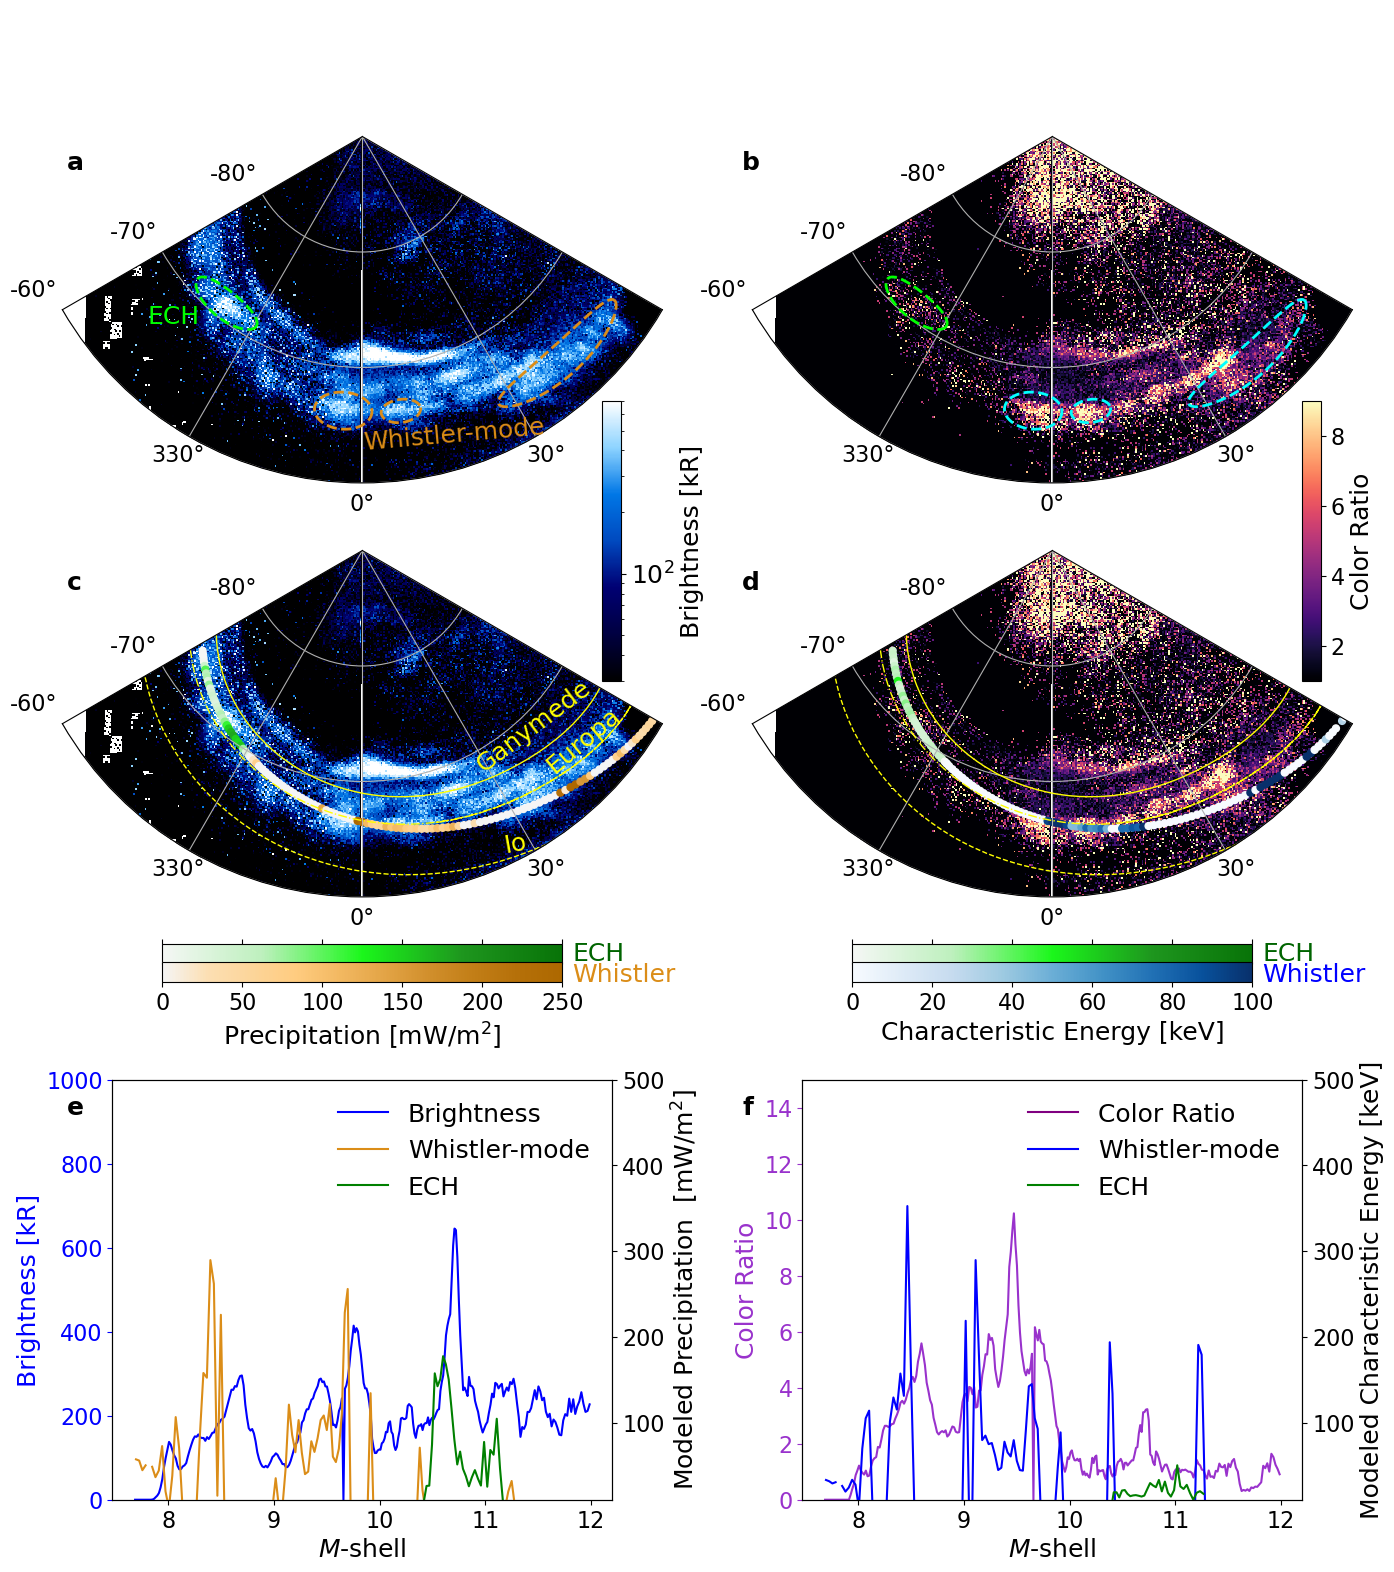

In [5]:
circle_angles = np.linspace(0, 2 * np.pi, 100)

whistler_color = '#db8d18'
whistler='orangered'
ech_color='lime'

'''Circle each of the auroral patches'''

center_lat2 = -66.2 
center_lon2 = 356 
lat_radius2 = 1.6   
lon_radius2 = 6    
circle_lon2 = center_lon2 + lon_radius2 * np.cos(circle_angles)
circle_lat2 = center_lat2 + lat_radius2 * np.sin(circle_angles)
circle_theta2 = np.deg2rad(circle_lon2)
circle_r2 = circle_lat2

center_lat3 = -66 
center_lon3 = 368
lat_radius3 = 1   
lon_radius3 = 4.1   
circle_lon3 = center_lon3 + lon_radius3 * np.cos(circle_angles)
circle_lat3 = center_lat3 + lat_radius3 * np.sin(circle_angles)
circle_theta3 = np.deg2rad(circle_lon3)
circle_r3 = circle_lat3

center_lat4 = -64 
center_lon4 = 402  
lat_radius4 = 1.4   
lon_radius4 = 15
circle_lon4 = center_lon4 + lon_radius4 * np.cos(circle_angles)
circle_lat4 = center_lat4 + lat_radius4 * np.sin(circle_angles)
circle_theta4 = np.deg2rad(circle_lon4)
circle_r4 = circle_lat4

center_lat5 = -71.2
center_lon5 = 320.8
lat_radius5 = 1.2   
lon_radius5 = 10
circle_lon5 = center_lon5 + lon_radius5 * np.cos(circle_angles)
circle_lat5 = center_lat5 + lat_radius5 * np.sin(circle_angles)
circle_theta5 = np.deg2rad(circle_lon5)
circle_r5 = circle_lat5

longitude_ticks = np.radians([330, 360,390])
longitude_labels = ['330°', '0°','30°']



custom_cmap4 = matplotlib.colors.LinearSegmentedColormap.from_list("custom",['#f5f5f5','#fcdfb3','#fcd59a','#ffcc80','#f2b861','#e3a446','#d18f2c','#c27e17','#b57009','#ad6800'])

fig = plt.figure(figsize=(10, 14))  
ax0 = fig.add_subplot(111, projection='polar', facecolor='none')
c = ax0.pcolormesh(theta, r, brightness, cmap=custom_cmap,norm=LogNorm(vmin=30,vmax=700))
cbar0 = plt.colorbar(c, ax=ax0, shrink=0.5,pad=-0.1,aspect=15,fraction=0.05) #full scale
cbar0.ax.set_position([0.47, 0.935, 0.3, 0.2])
ax0.set_position([-0.07, 0.9, 0.6, 0.6])  # [left, bottom, width, height]
ax0.plot(circle_theta2, circle_r2, color=whistler_color, linestyle='--', linewidth=2, label='Approximate Circle')
ax0.plot(circle_theta3, circle_r3, color=whistler_color, linestyle='--', linewidth=2, label='Approximate Circle')
ax0.plot(circle_theta4, circle_r4, color=whistler_color, linestyle='--', linewidth=2, label='Approximate Circle')
ax0.plot(circle_theta5, circle_r5, color=ech_color, linestyle='--', linewidth=2, label='Approximate Circle')

cbar0.ax.tick_params(labelsize=18)
ax0.set_theta_offset(-np.pi / 2.0)
ax0.set_yticklabels(['-80°','-70°','-60°'])
ax0.set_rticks([-80,-70,-60])
ax0.set_rlim(-90,-60)
ax0.set_xticks(longitude_ticks)
ax0.set_xticklabels(longitude_labels)
ax0.yaxis.set_label_position("left")
ax0.set_thetamin(300)
ax0.set_thetamax(420)
ax0.tick_params(axis='x',pad=5,labelsize=16)
ax0.tick_params(axis='y',labelsize=16)
cbar0.set_label('Brightness [kR]',fontsize=18)
########################################################################################
ax01 = fig.add_subplot(111, projection='polar', facecolor='none')
c01 = ax01.pcolormesh(theta, r, CR, cmap='magma',vmin=1,vmax=9)
cbar01 = plt.colorbar(c01, ax=ax01, shrink=0.5,aspect=15,pad=-0.1,fraction=0.05) #full scale
cbar01.ax.set_position([1.17, 0.935, 0.3, 0.2])  # [left, bottom, width, height] for the colorbar
ax01.set_position([0.62, 0.9, 0.6, 0.6])  # [left, bottom, width, height]
ax01.plot(circle_theta2, circle_r2, color='cyan', linestyle='--', linewidth=2, label='Approximate Circle')
ax01.plot(circle_theta3, circle_r3, color='cyan', linestyle='--', linewidth=2, label='Approximate Circle')
ax01.plot(circle_theta4, circle_r4, color='cyan', linestyle='--', linewidth=2, label='Approximate Circle')
ax01.plot(circle_theta5, circle_r5, color=ech_color, linestyle='--', linewidth=2, label='Approximate Circle')
ax01.set_yticklabels(['-80°','-70°','-60°'])
cbar01.ax.tick_params(labelsize=16)
ax01.set_theta_offset(-np.pi / 2.0)
ax01.set_rticks([-80,-70,-60])
ax01.set_rlim(-90,-60)
ax01.set_xticks(longitude_ticks)
ax01.set_xticklabels(longitude_labels)
ax01.yaxis.set_label_position("left")
ax01.set_thetamin(300)
ax01.set_thetamax(420)
ax01.tick_params(axis='x',pad=5,labelsize=16)
ax01.tick_params(axis='y',labelsize=16)
cbar01.set_label('Color Ratio',fontsize=18)
########################################################################################
polar_ax = fig.add_subplot(111, projection='polar', facecolor='none')
c = polar_ax.pcolormesh(theta, r, brightness, cmap=custom_cmap,norm=LogNorm(vmin=30,vmax=700))
polar_ax.plot(Longitude_io_rad, Latitude_io, color='yellow',linewidth=1,linestyle='--')
polar_ax.plot(Longitude_Eu_rad, Latitude_Eu, color='yellow',linewidth=1,linestyle='dashdot')
polar_ax.plot(Longitude_Ga_rad, Latitude_Ga, color='yellow',linewidth=1)
scatter = polar_ax.scatter(filtered_lon_ech, filtered_lat_ech, 
                     c=filtered_flux_ech, marker='o', s=25, 
                     vmin=0, vmax=250, cmap=custom_cmap2)
scatter2 = polar_ax.scatter(filtered_lon_chorus, filtered_lat_chorus, 
                            c=filtered_flux_chorus, marker='o', s=25, 
                            vmin=0, vmax=250, cmap=custom_cmap4)
cbar = plt.colorbar(scatter, ax=polar_ax,orientation='horizontal', shrink=0.5,pad=-0.02) #full scale
cbar3 = plt.colorbar(scatter2, ax=polar_ax,orientation='horizontal', shrink=0.5,pad=0.0) #full scale

cbar.ax.set_position([0.03, 0.547, 0.4, 0.2])  # [left, bottom, width, height] for the colorbar
cbar3.ax.set_position([0.03, 0.534, 0.4, 0.2])  # [left, bottom, width, height] for the colorbar
polar_ax.set_position([-0.07, 0.69, 0.6, 0.6])  # [left, bottom, width, height]

cbar3.ax.tick_params(labelsize=16)

polar_ax.set_theta_offset(-np.pi / 2.0)
polar_ax.set_rticks([-80,-70,-60])
polar_ax.set_rlim(-90,-60)
polar_ax.set_xticks(longitude_ticks)
polar_ax.set_xticklabels(longitude_labels)

polar_ax.set_yticklabels(['-80°','-70°','-60°'])
polar_ax.yaxis.set_label_position("left")
polar_ax.set_thetamin(300)
polar_ax.set_thetamax(420)
polar_ax.tick_params(axis='x',pad=5,labelsize=16)
polar_ax.tick_params(axis='y',labelsize=16)
cbar3.set_label('Precipitation [mW/m$^2$]',color='black',fontsize=18)
cbar.ax.xaxis.set_ticks_position('top')  # Move ticks to top
cbar.ax.xaxis.set_tick_params(labeltop=False, labelbottom=False)  # Hide tick labels
###################################################################################################
CR_ax = fig.add_subplot(111, projection='polar', facecolor='none')
c_cr = CR_ax.pcolormesh(theta, r, CR, cmap='magma',vmin=1,vmax=9)
CR_ax.plot(Longitude_io_rad, Latitude_io, color='yellow',linewidth=1,linestyle='--')
CR_ax.plot(Longitude_Eu_rad, Latitude_Eu, color='yellow',linewidth=1,linestyle='dashdot')
CR_ax.plot(Longitude_Ga_rad, Latitude_Ga, color='yellow',linewidth=1)
CR_ax.set_yticklabels(['-80°','-70°','-60°'])
scatter_cr = CR_ax.scatter(filtered_lon_ech_ch, filtered_lat_ech_ch, 
                     c=filtered_flux_ech_ch, marker='o', s=25, 
                     vmin=0, vmax=100,cmap=custom_cmap2)
scatter2_cr = CR_ax.scatter(filtered_lon_chorus_ch, filtered_lat_chorus_ch, 
                     c=filtered_flux_chorus_ch, marker='o', s=25, 
                     vmin=0, vmax=100, cmap='Blues')
cbar_cr = plt.colorbar(scatter_cr, ax=CR_ax,orientation='horizontal', shrink=0.5,pad=-0.02) #full scale
cbar3_cr = plt.colorbar(scatter2_cr, ax=CR_ax,orientation='horizontal', shrink=0.5,pad=0.0) #full scale

cbar_cr.ax.set_position([0.72, 0.547, 0.4, 0.2]) 
cbar3_cr.ax.set_position([0.72, 0.534, 0.4, 0.2])  

CR_ax.set_position([0.62, 0.69, 0.6, 0.6])  
cbar_cr.ax.tick_params(labelsize=16)
cbar3_cr.ax.tick_params(labelsize=16)

CR_ax.set_theta_offset(-np.pi / 2.0)
CR_ax.set_rticks([-80,-70,-60])
CR_ax.set_rlim(-90,-60)
CR_ax.set_xticks(longitude_ticks)
CR_ax.set_xticklabels(longitude_labels)
CR_ax.yaxis.set_label_position("left")
CR_ax.set_thetamin(300)
CR_ax.set_thetamax(420)
CR_ax.tick_params(axis='x',pad=5,labelsize=16)
CR_ax.tick_params(axis='y',labelsize=16)
cbar3_cr.set_label('Characteristic Energy [keV]',color='black',fontsize=18)
cbar_cr.ax.xaxis.set_ticks_position('top')  # Move ticks to top
cbar_cr.ax.xaxis.set_tick_params(labeltop=False, labelbottom=False)  

ax2 = fig.add_axes([0.67, 0.35, 0.5, 0.3])  # bottom right plot
ax2.plot(data_grouped['Mshell'], CR_along_path, color='darkorchid', label='Color Ratio')
ax2.set_ylabel('Color Ratio', color='darkorchid',fontsize=18)
ax2.tick_params(axis='y', labelcolor='darkorchid')
ax2.set_ylim(0, 15)
ax2.spines['right'].set_color('black')

ax2.tick_params(axis='y', colors='darkorchid')
ax1 = ax2.twinx()
ax1.spines['right'].set_position(('outward', 0))  # Make sure it's on the left side
ax1.plot(Ch_chorus_df_grouped['Mshell'], Ch_chorus_df_grouped['Char_E'], color='b', label='Whistler-mode')
ax1.tick_params(axis='y', labelcolor='black')
ax1.set_ylim(10, 500)
ax1.set_ylabel('')  

ax1.plot(ECH_df_grouped['Mshell'], ECH_df_grouped['Char_E'], color='g', label='ECH')
ax1.set_ylabel('Modeled Characteristic Energy [keV]',fontsize=18)  

ax2.tick_params(axis='y', labelsize=16)  
ax1.tick_params(axis='y', labelsize=16)  
ax2.tick_params(axis='x', labelsize=16)  

lines = [
    plt.Line2D([0], [0], color='purple', label='Color Ratio'),
    plt.Line2D([0], [0], color='b', label='Whistler-mode'),
    plt.Line2D([0], [0], color='green', label='ECH'),
]
ax2.legend(handles=lines, loc='best',fontsize=18,frameon=False)
ax2.set_xlabel('$M$-shell',fontsize=18)
##############
ax4 = fig.add_axes([-0.02, 0.35, 0.5, 0.3])  # Top right plot
ax4.plot(data_grouped['Mshell'], brightness_along_path, color='blue', label='Brightness')

ax4.set_ylabel('Brightness [kR]', color='blue', fontsize=18)
ax4.tick_params(axis='y', labelcolor='blue')
ax4.set_ylim(0, 1000)
ax4.spines['right'].set_color('black')
ax4.yaxis.label.set_color('blue')
ax4.tick_params(axis='y', colors='blue')

ax5 = ax4.twinx()
ax5.spines['right'].set_position(('outward', 0))  # Keep it on the right
ax5.plot(P_chorus_df_grouped['Mshell'], P_chorus_df_grouped['Flux_prec'], color=whistler_color, label='Whistler-mode')
ax5.plot(ECH_df_grouped['Mshell'], ECH_df_grouped['Flux_prec'], color='g', label='ECH')
ax5.tick_params(axis='y', labelcolor='black')  
ax5.set_ylim(10, 500)

ax5.set_ylabel('Modeled Precipitation  [mW/m$^2$]', fontsize=18)
ax4.tick_params(axis='y', labelsize=16)
ax5.tick_params(axis='y', labelsize=16)
ax4.tick_params(axis='x', labelsize=16)

lines = [
    plt.Line2D([0], [0], color='blue', label='Brightness'),
    plt.Line2D([0], [0], color=whistler_color, label='Whistler-mode'),
    plt.Line2D([0], [0], color='green', label='ECH'),
]
ax4.legend(handles=lines, loc='upper right',fontsize=18,frameon=False)
ax4.set_xlabel('$M$-shell',fontsize=18)
fig.text(-0.065,1.3,'a',fontsize=18,color='black',fontweight='bold')
fig.text(0.61,1.3,'b',fontsize=18,color='black',fontweight='bold')
fig.text(-0.065,1.0,'c',fontsize=18,color='black',fontweight='bold')
fig.text(0.61,1.0,'d',fontsize=18,color='black',fontweight='bold')
fig.text(-0.065,0.625,'e',fontsize=18,color='black',fontweight='bold')
fig.text(0.61,0.625,'f',fontsize=18,color='black',fontweight='bold')
fig.text(0.34,0.87,'Ganymede',rotation=37,fontsize=18,color='yellow')
fig.text(0.41,0.869,'Europa',rotation=40,fontsize=18,color='yellow')
fig.text(0.37,0.812,'Io',rotation=10,fontsize=18,color='yellow')
fig.text(0.23,1.1,'Whistler-mode',rotation=5,fontsize=18,color=whistler_color)
fig.text(0.015,1.19,'ECH',fontsize=18,color='lime')

fig.text(0.44,0.72,'Whistler',fontsize=18,color=whistler_color)
fig.text(0.44,0.735,'ECH',fontsize=18,color='darkgreen')
fig.text(1.13,0.72,'Whistler',fontsize=18,color='blue')
fig.text(1.13,0.735,'ECH',fontsize=18,color='darkgreen')
plt.show()